```bash
conda create --name cellpose python=3.8 -y
conda activate cellpose
pip install cellpose[all]
pip uninstall torch -y
conda install pytorch cudatoolkit=10.2 cuml=0.19.0 -c pytorch -c rapidsai -c nvidia -y
pip install matplotlib trackpy ipykernel seaborn numpy=1.20 -y
python -m ipykernel install --user --name cellpose
```

In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io
import cellpose
from cellpose import plot
from cellpose import models, io
model = models.Cellpose(gpu=True, model_type='cyto')

In [2]:
marker="Serpine2"

In [3]:
import scipy.sparse as sp
def get_means(file,diam=None,thre_sox10=0):
    csv=file.split("(RGB)")[0]+"(RGB).csv"
    img = io.imread(file)
    if img.shape[0]==3:
        img=np.moveaxis(img,0,2)
    channels = [2,0]
    masks, flows, styles, diams = model.eval(img, diameter=diam, channels=channels,)

    ids=np.unique(masks)[1:]
    mm=sp.csr_matrix(masks)
    # remove background
    bckgrd=pd.read_csv(csv)["Mean"][0]
    zeros=(img[:,:,0]-bckgrd)<0
    img[:,:,0]=img[:,:,0]-bckgrd
    img[zeros,0]=0
    try:
        means=pd.DataFrame({marker:[img[(mm==i).nonzero()].mean(axis=0)[0] for i in ids],
                             "Sox10":[img[(mm==i).nonzero()].mean(axis=0)[1] for i in ids]},
                          index=ids)
        return means
    except IndexError:
        print("ERROR")
        with open("files2split.txt", "a") as file_object:
            # Append 'hello' at the end of file
            file_object.write(file)
            file_object.write("\n")

    


In [4]:
def get_locs(tp):
    locs=pd.Series([f.split("(RGB)")[1].split(".tif")[0][1:] for f in glob(tp+"/*")],
              index=glob(tp+"/*"))
    locs=locs.loc[locs!=""]
    
    return locs

In [5]:
path="input/Serpine2/*"

In [6]:
data={}

In [7]:
import pandas as pd
from glob import glob
from tqdm import tqdm
for tp in glob(path):
    locs=get_locs(tp)
    locations=locs.unique()
    ident=tp.split("No")[0].split("/")[-1]+tp.split("No")[1][0]
    locations=locations[locations!="csv"]
    for loc in locations:
        files_loc=locs.index[locs==loc]
        allmeans=list()
        for file in tqdm(files_loc,desc=ident+"_"+loc):
            allmeans.append(get_means(file,diam=20))
        allmeans = [i for i in allmeans if i is not None]
        for i in range(len(allmeans)):
            allmeans[i]["slide"]=i
        allmeans=pd.concat(allmeans)
        allmeans["slide"]=allmeans["slide"].astype(str)
        data[ident+"_"+loc]=allmeans

E10_2_nerve: 100%|██████████| 1/1 [00:14<00:00, 14.02s/it]


In [8]:
len(data)

31

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
km=KMeans(2)
def filter_kmean(exp):
    df=data[exp].copy()
    df=StandardScaler().fit_transform(df.values[:,:2])
    kclu=km.fit(df[:,:2])
    idx=np.argmin([data[exp][marker][kclu.labels_==0].mean(),data[exp][marker][kclu.labels_==1].mean()])
    data[exp]["keep"]=(kclu.labels_==idx).astype(str)

In [10]:
clean=[0 for i in range(len(data))]
clean=[0,50,50,50,40,20,0,0,20,0,20,1,1,1,1,1,1,1,1,1,1,50,0,0,0,0,25,25,25,25,30]

/tmp/ipykernel_2494978/1165627603.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs=plt.subplots(1,3,figsize=(6,3))


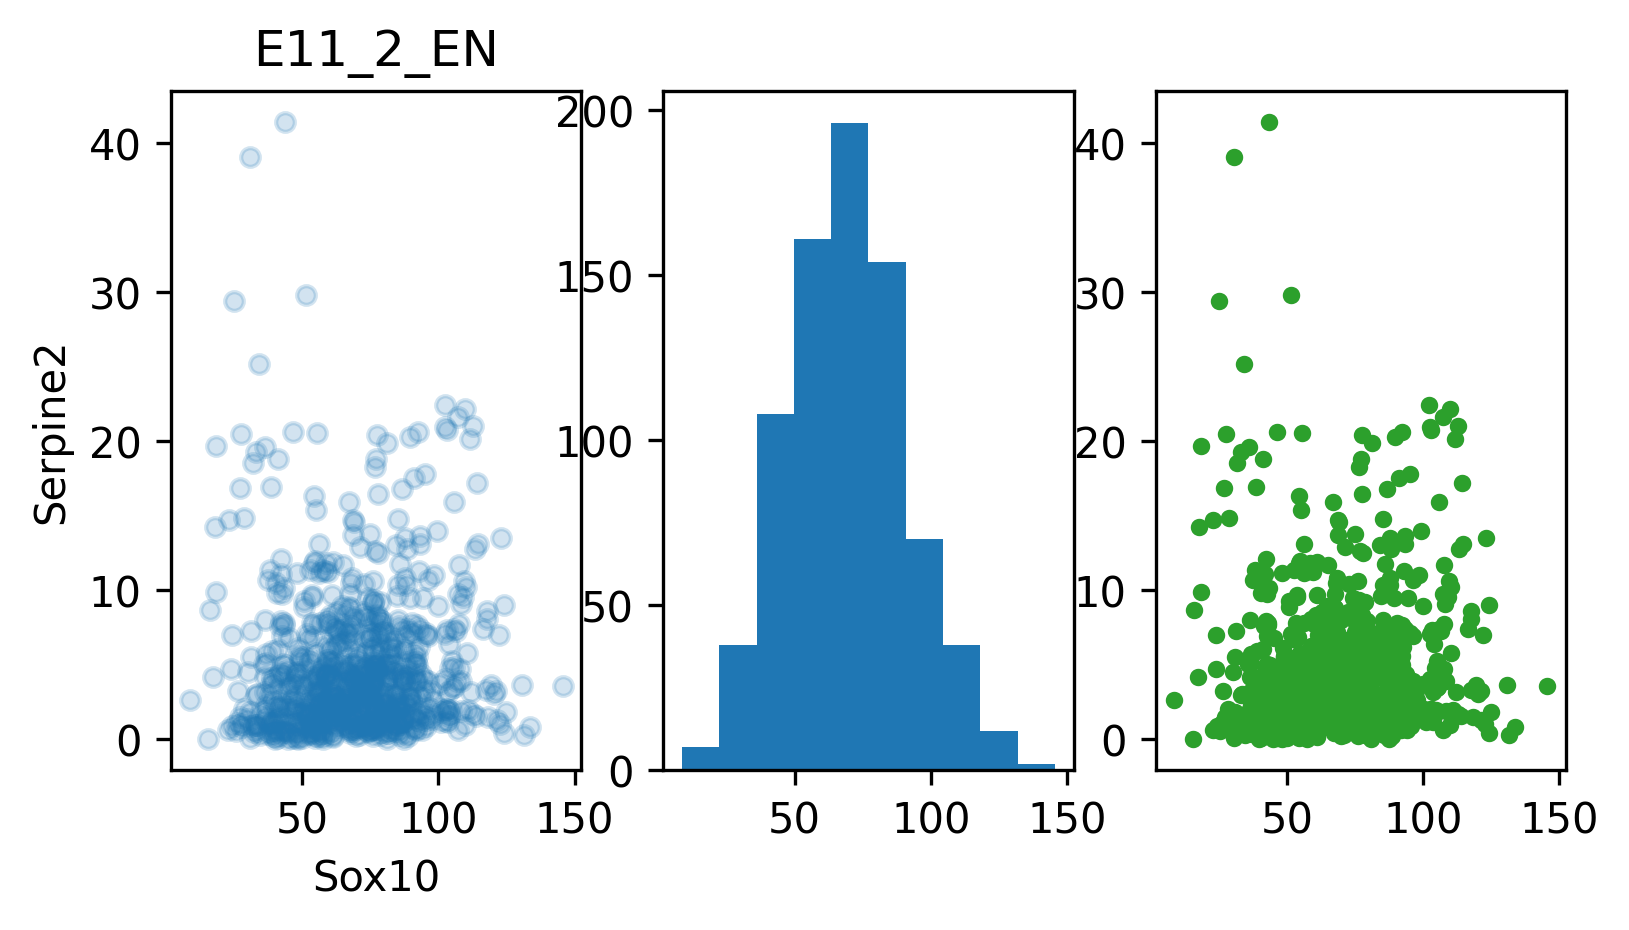

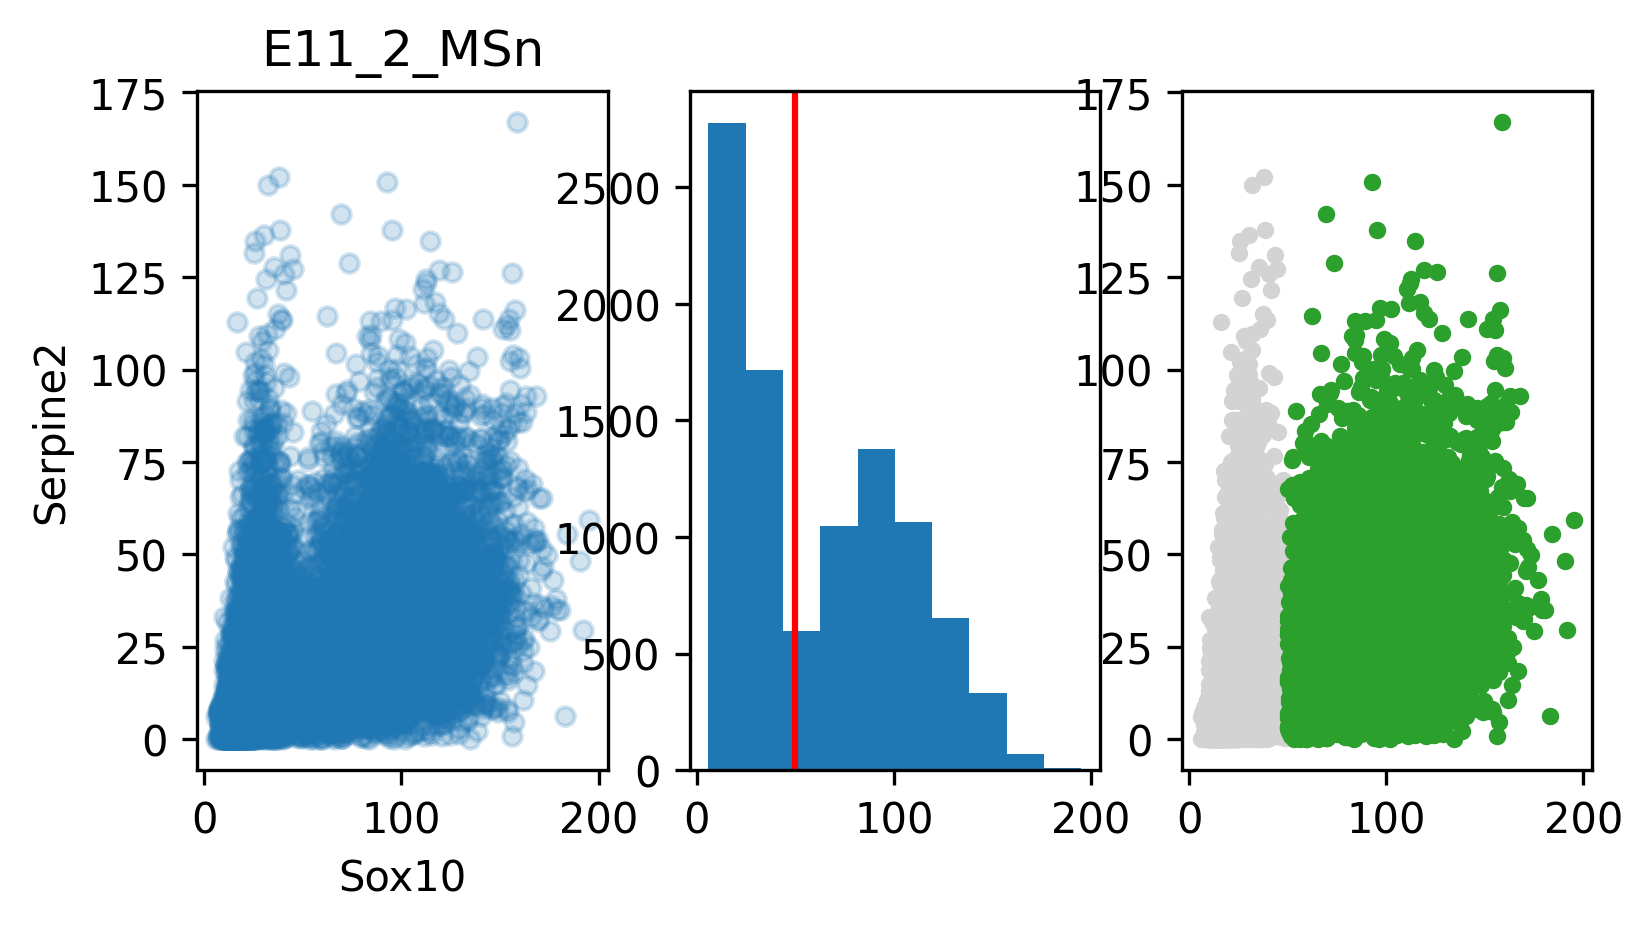

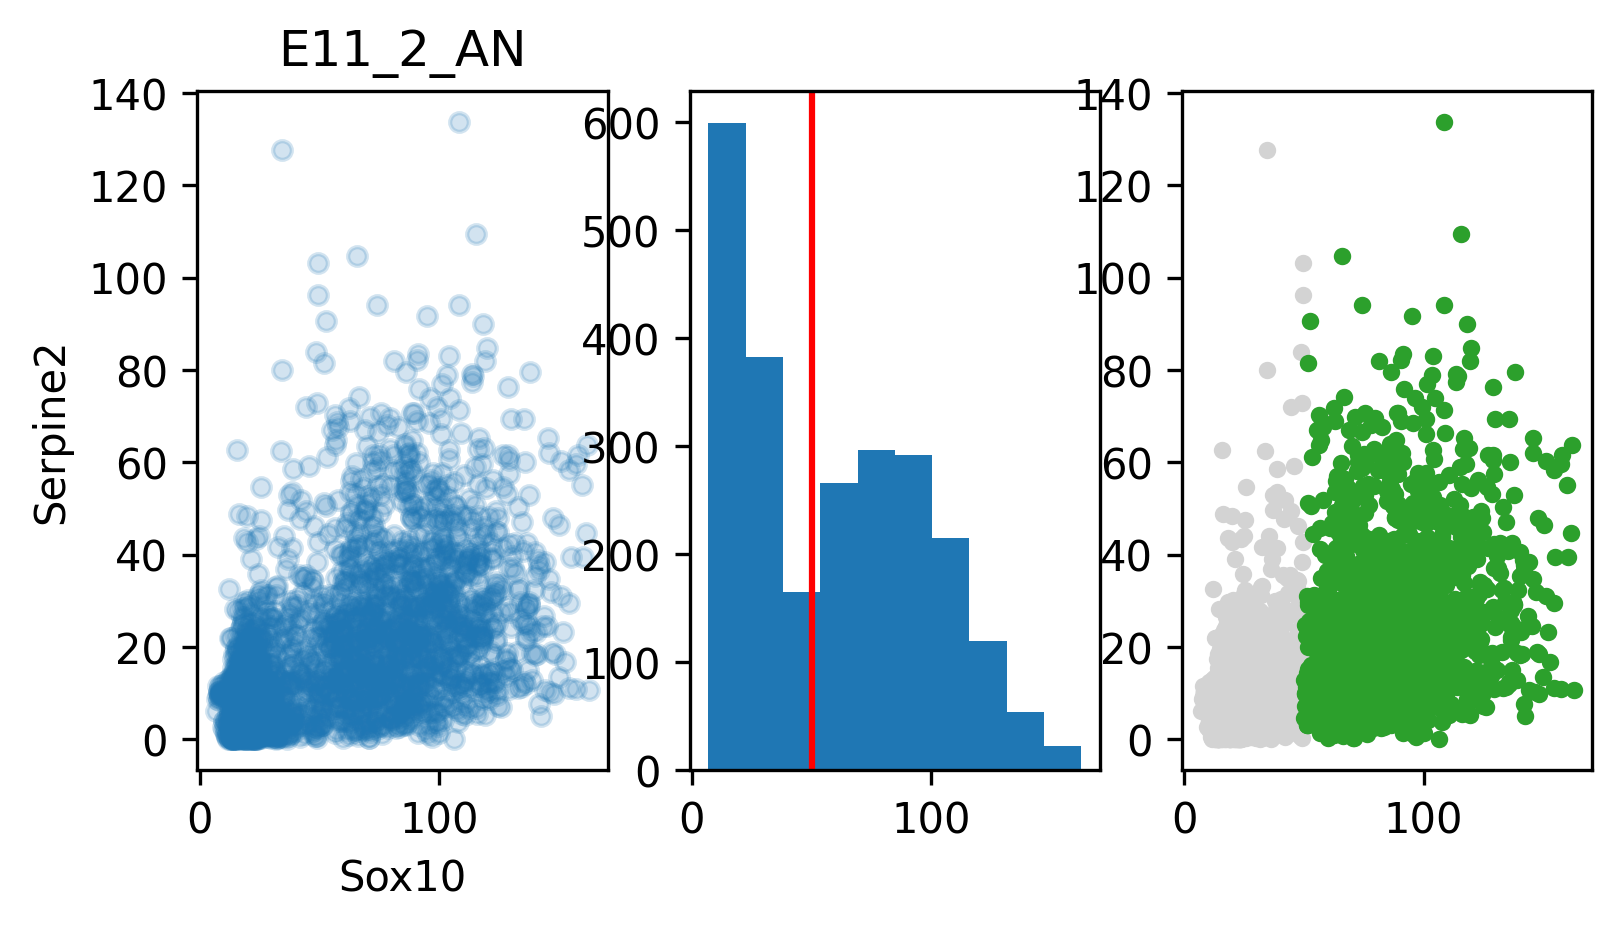

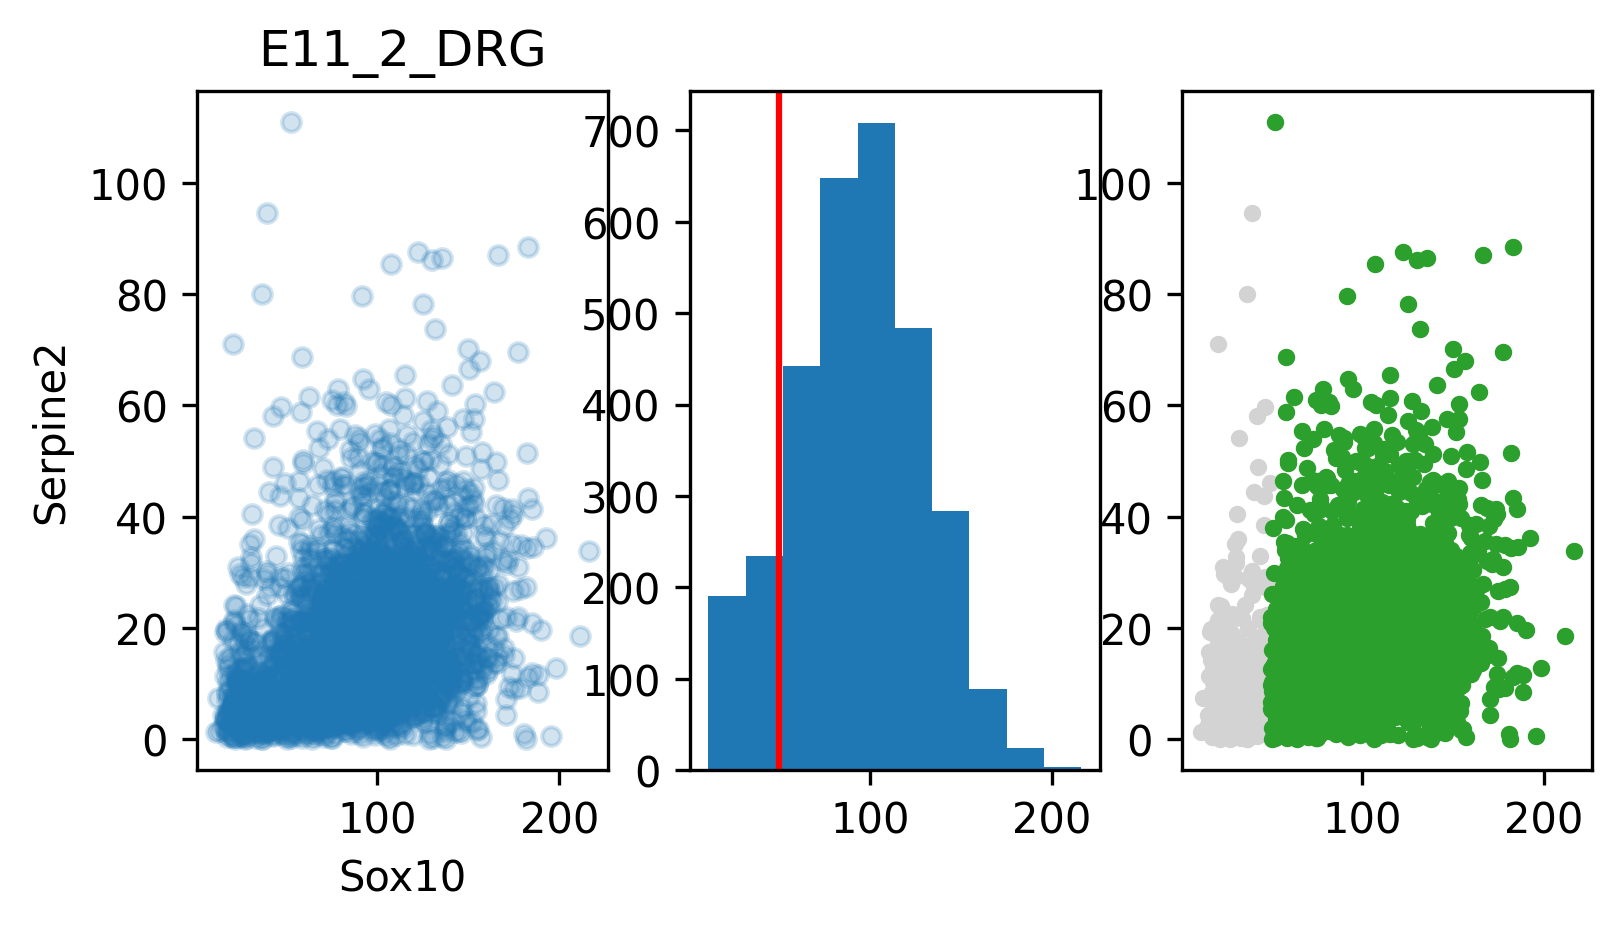

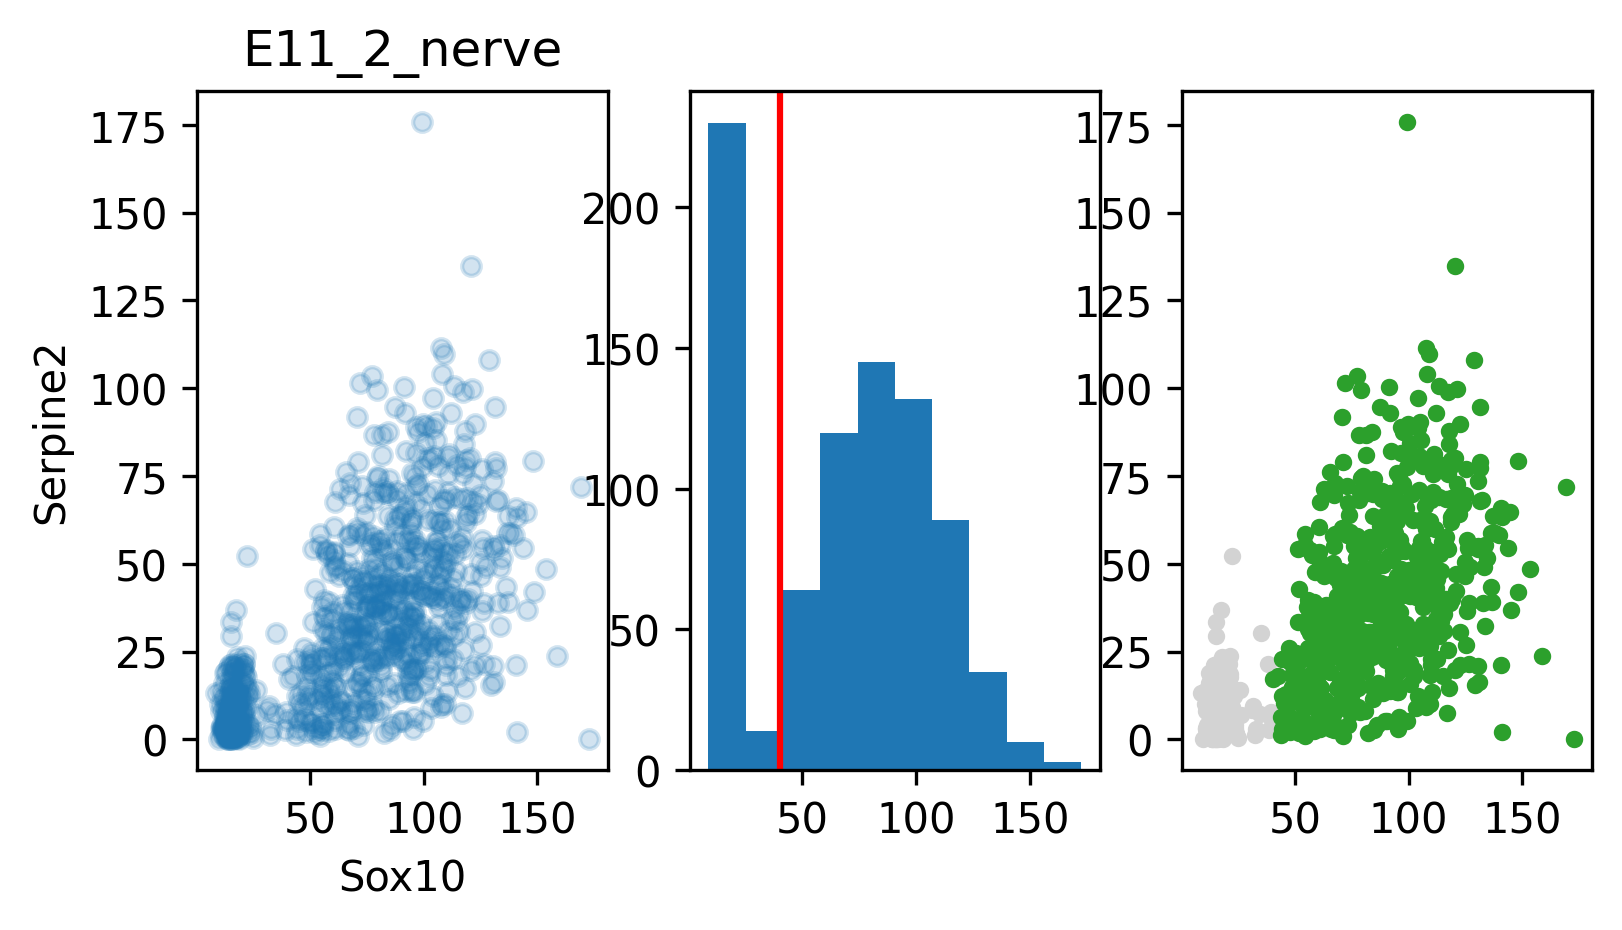

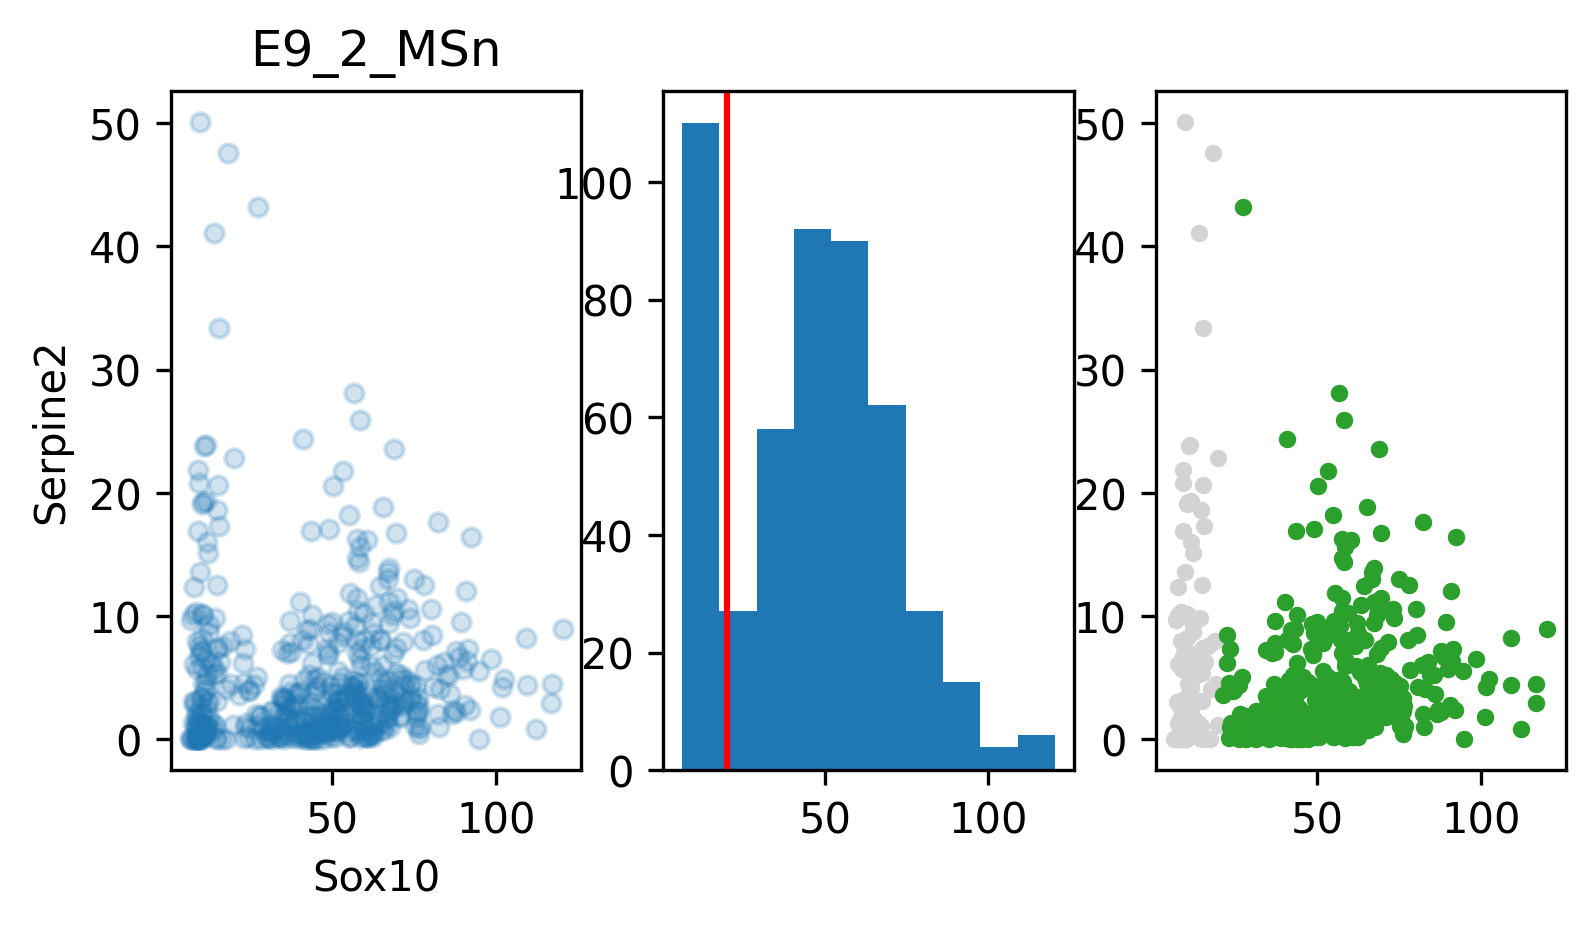

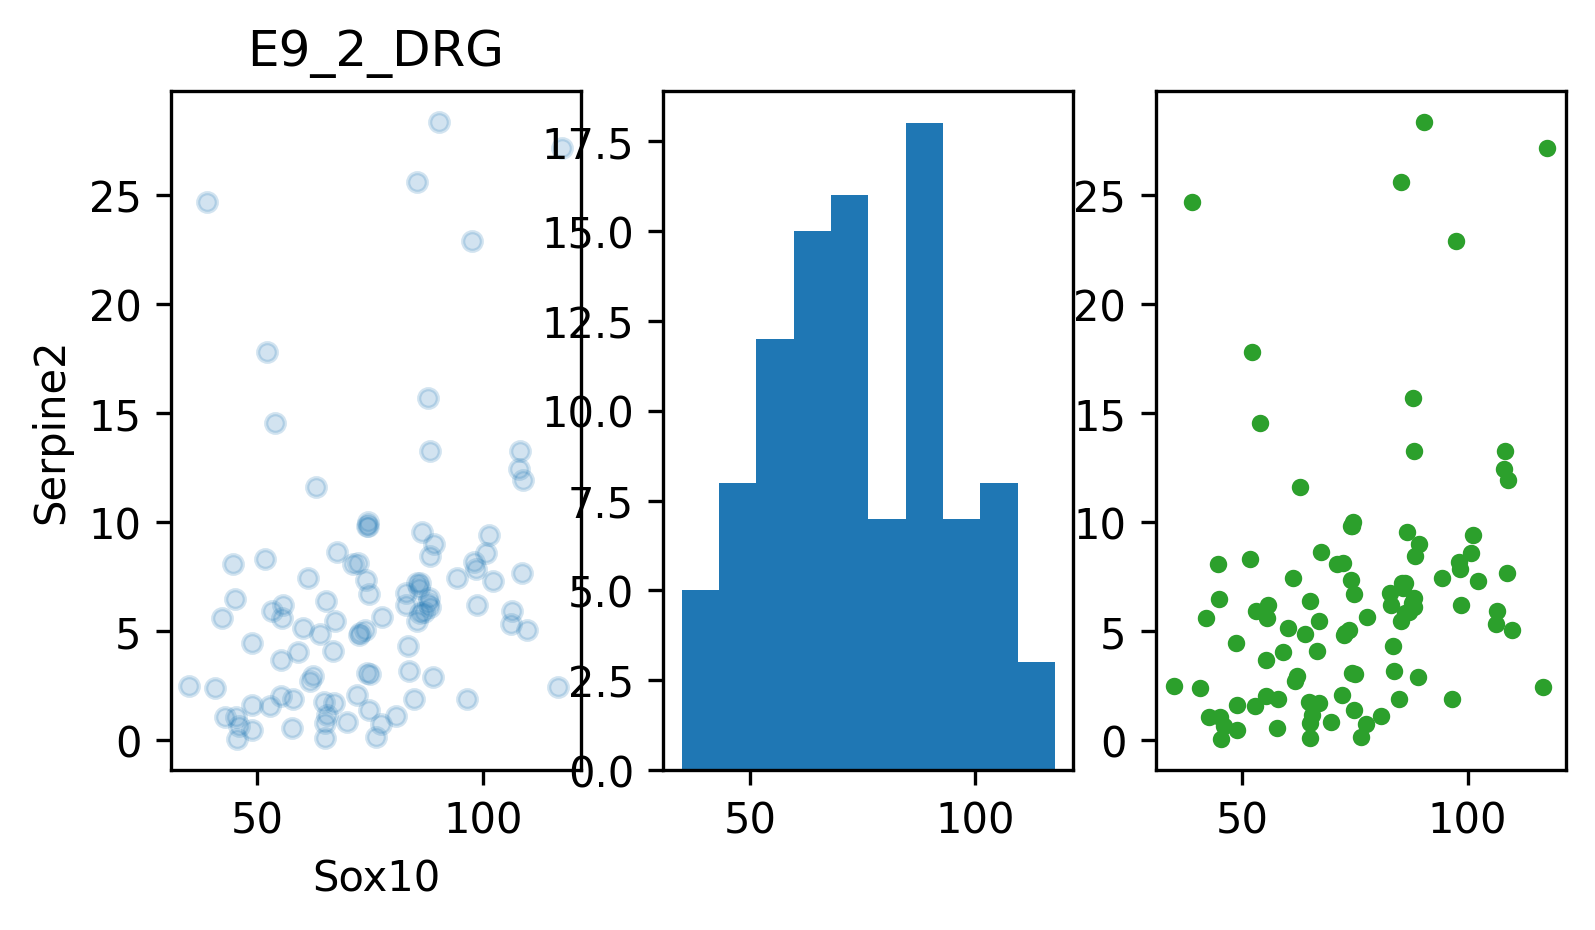

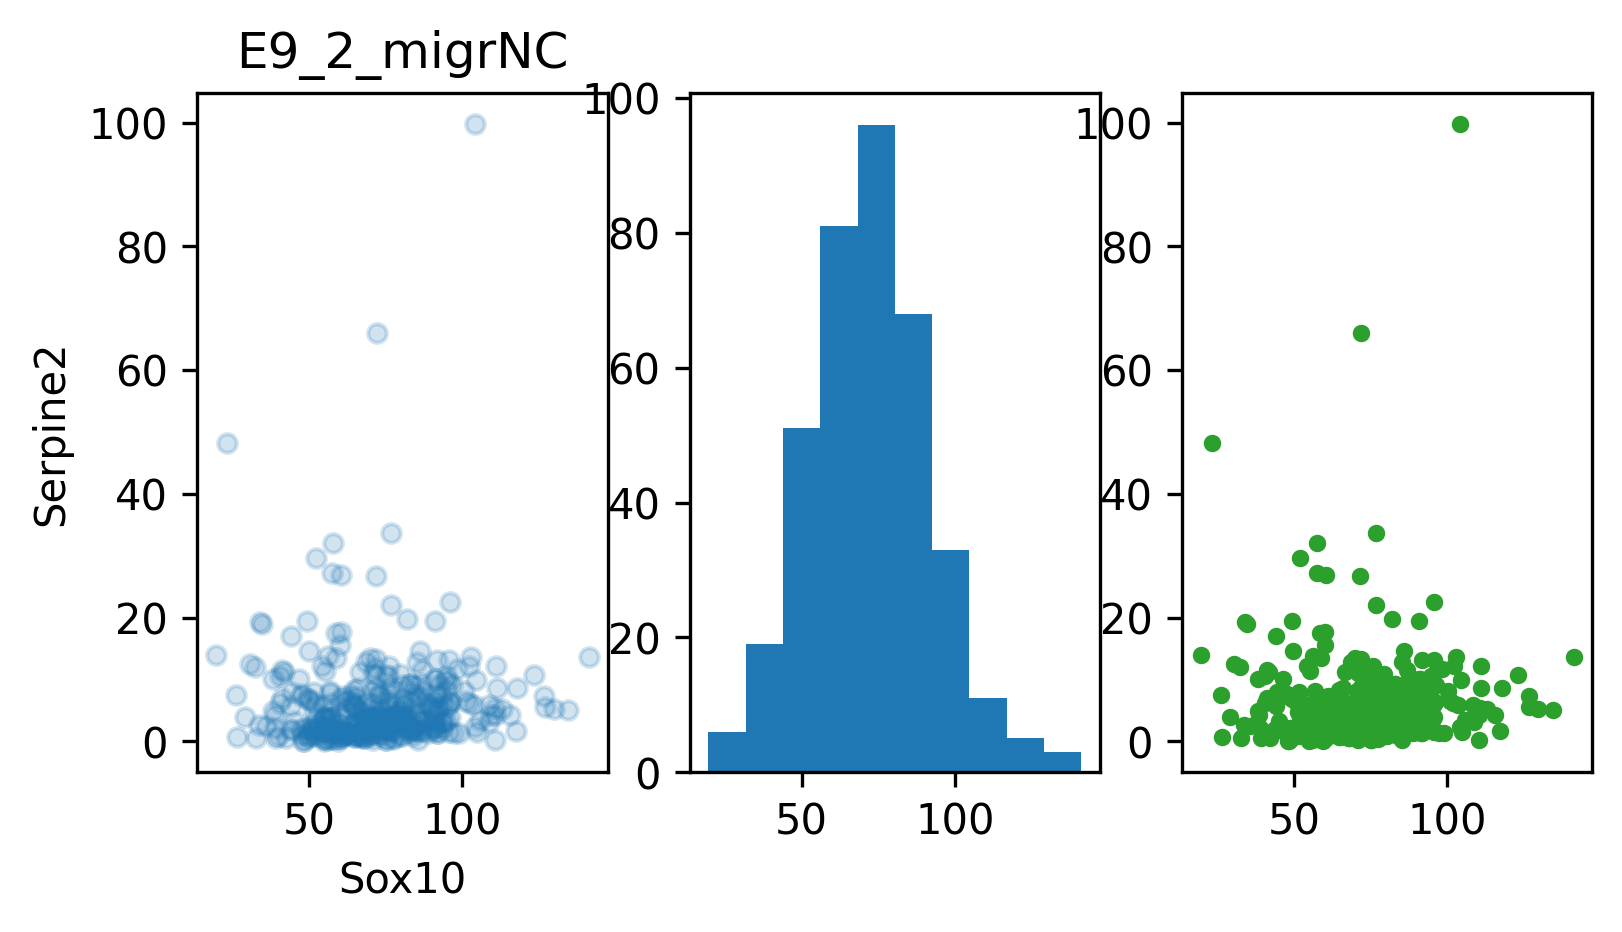

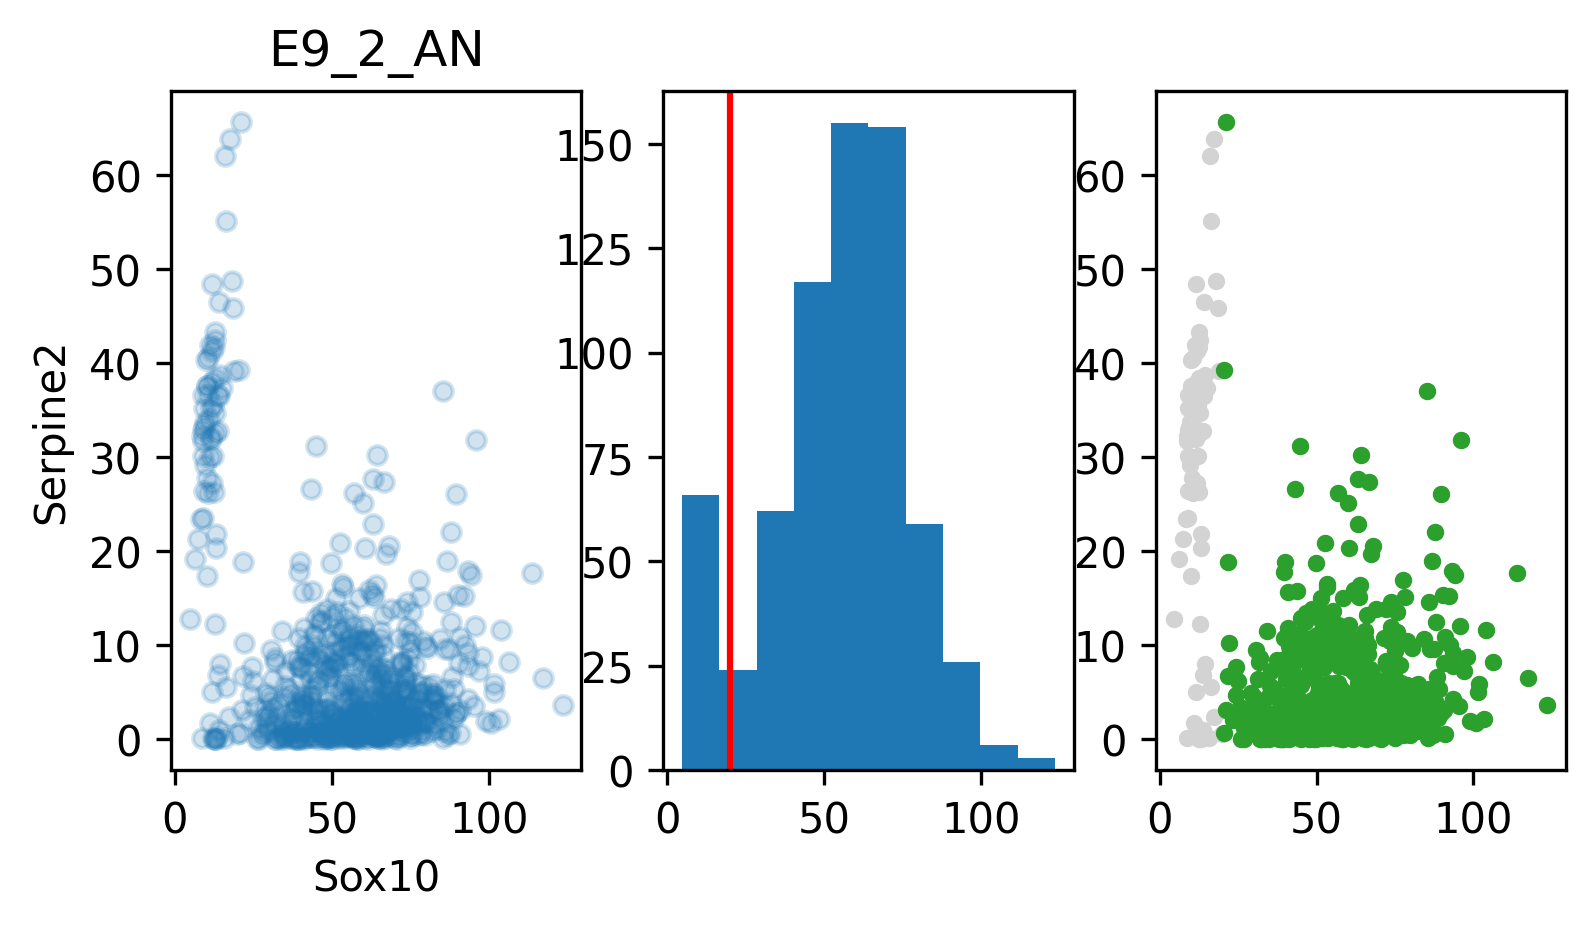

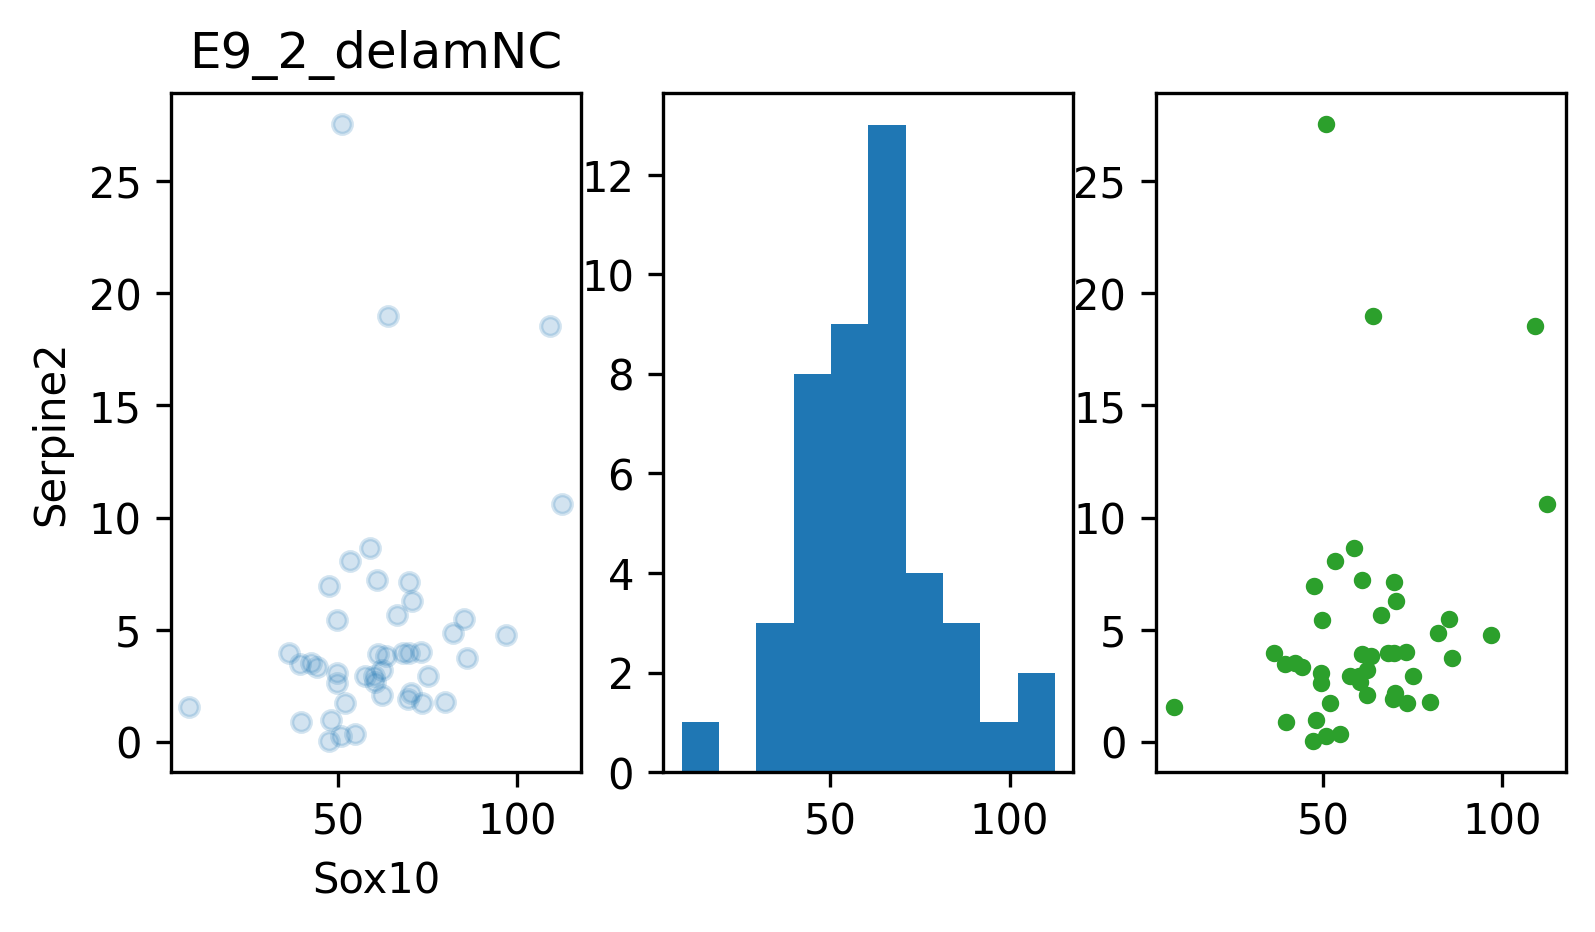

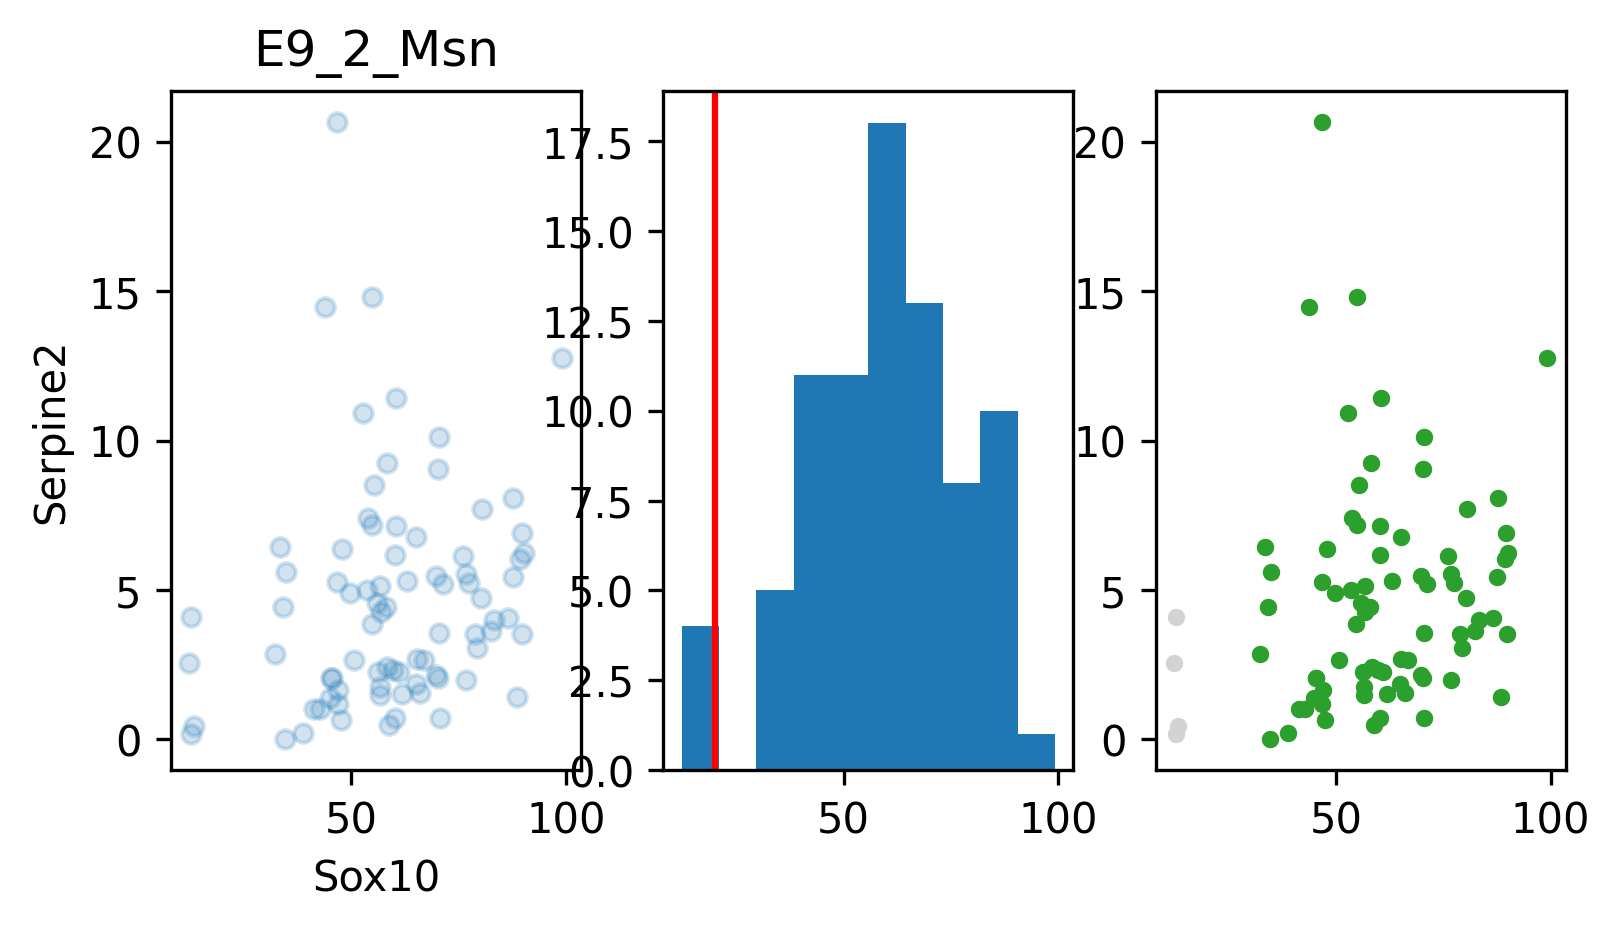

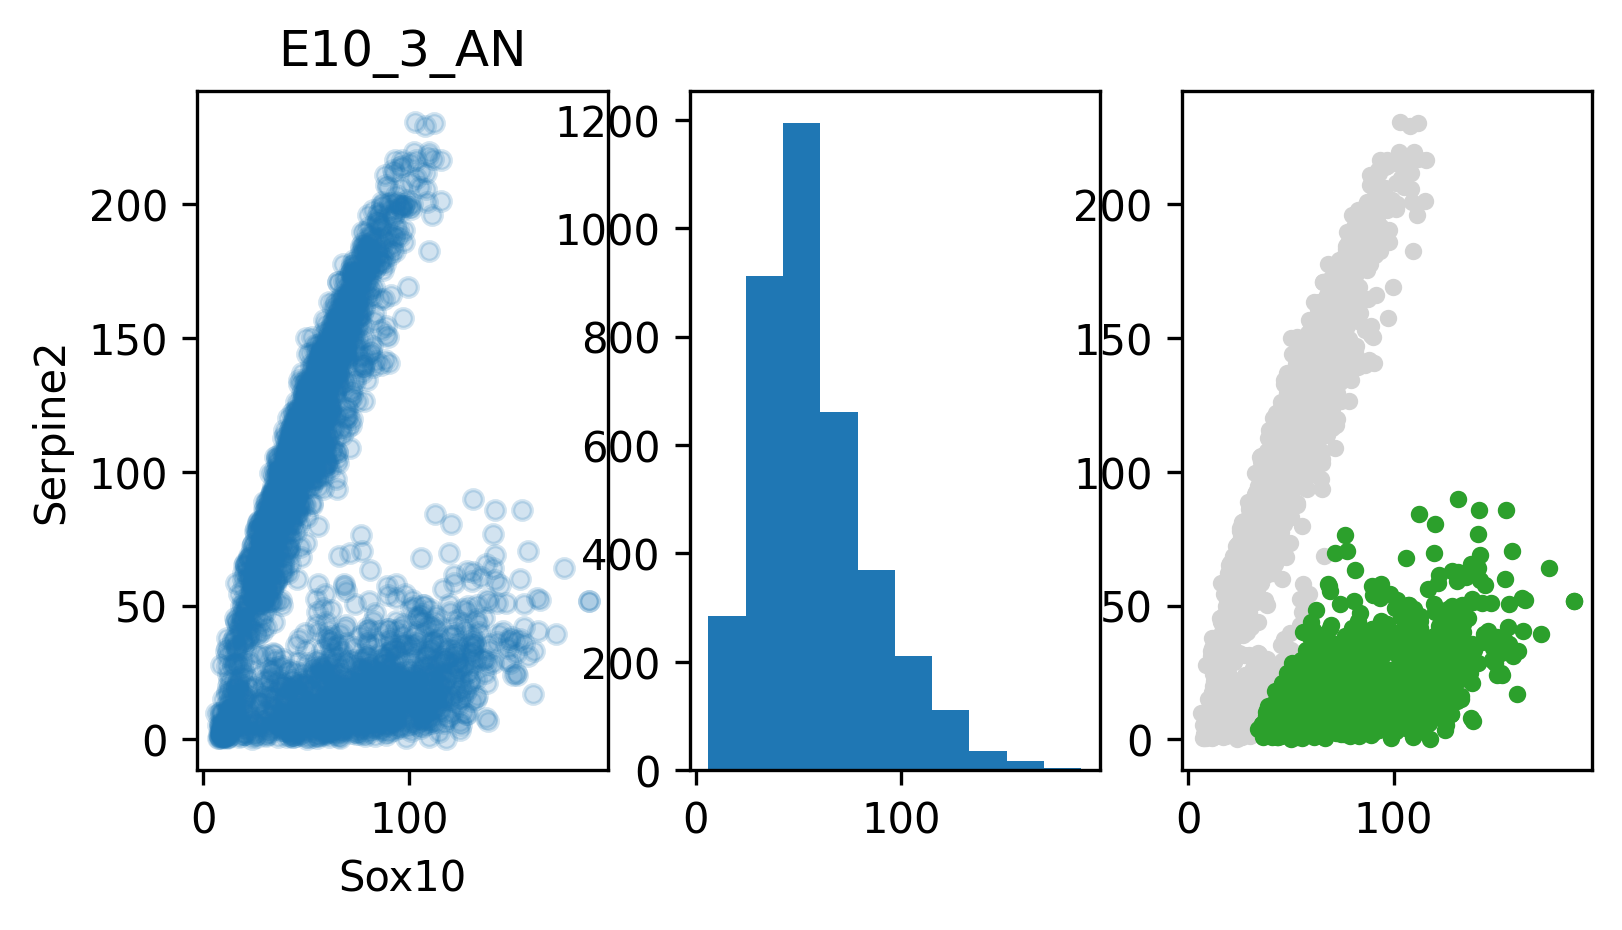

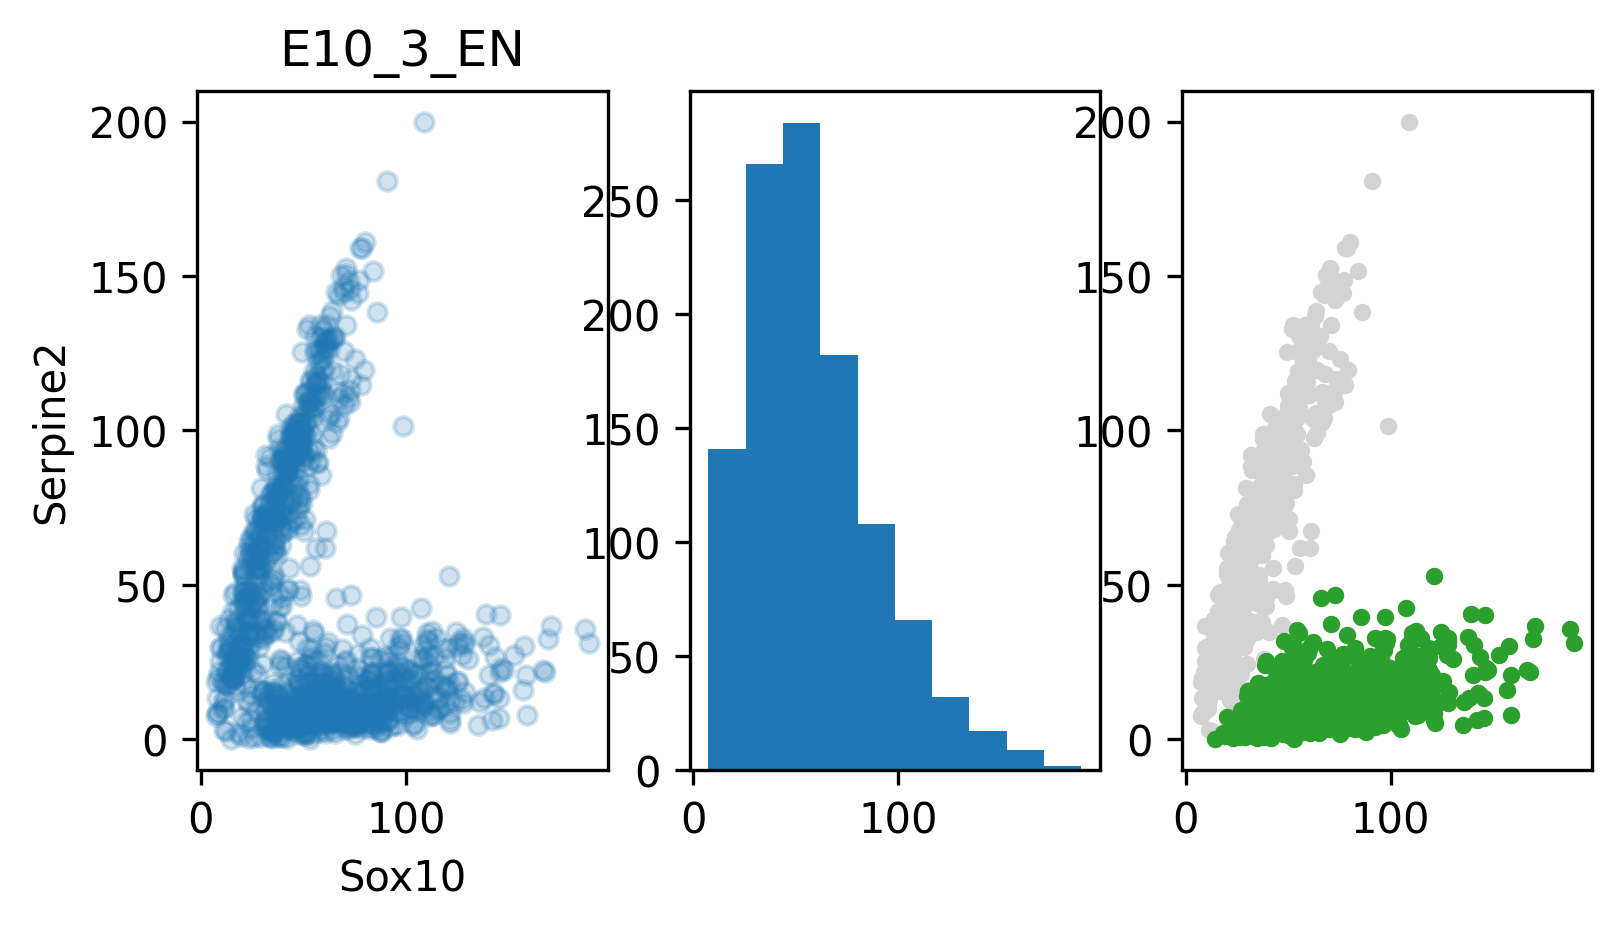

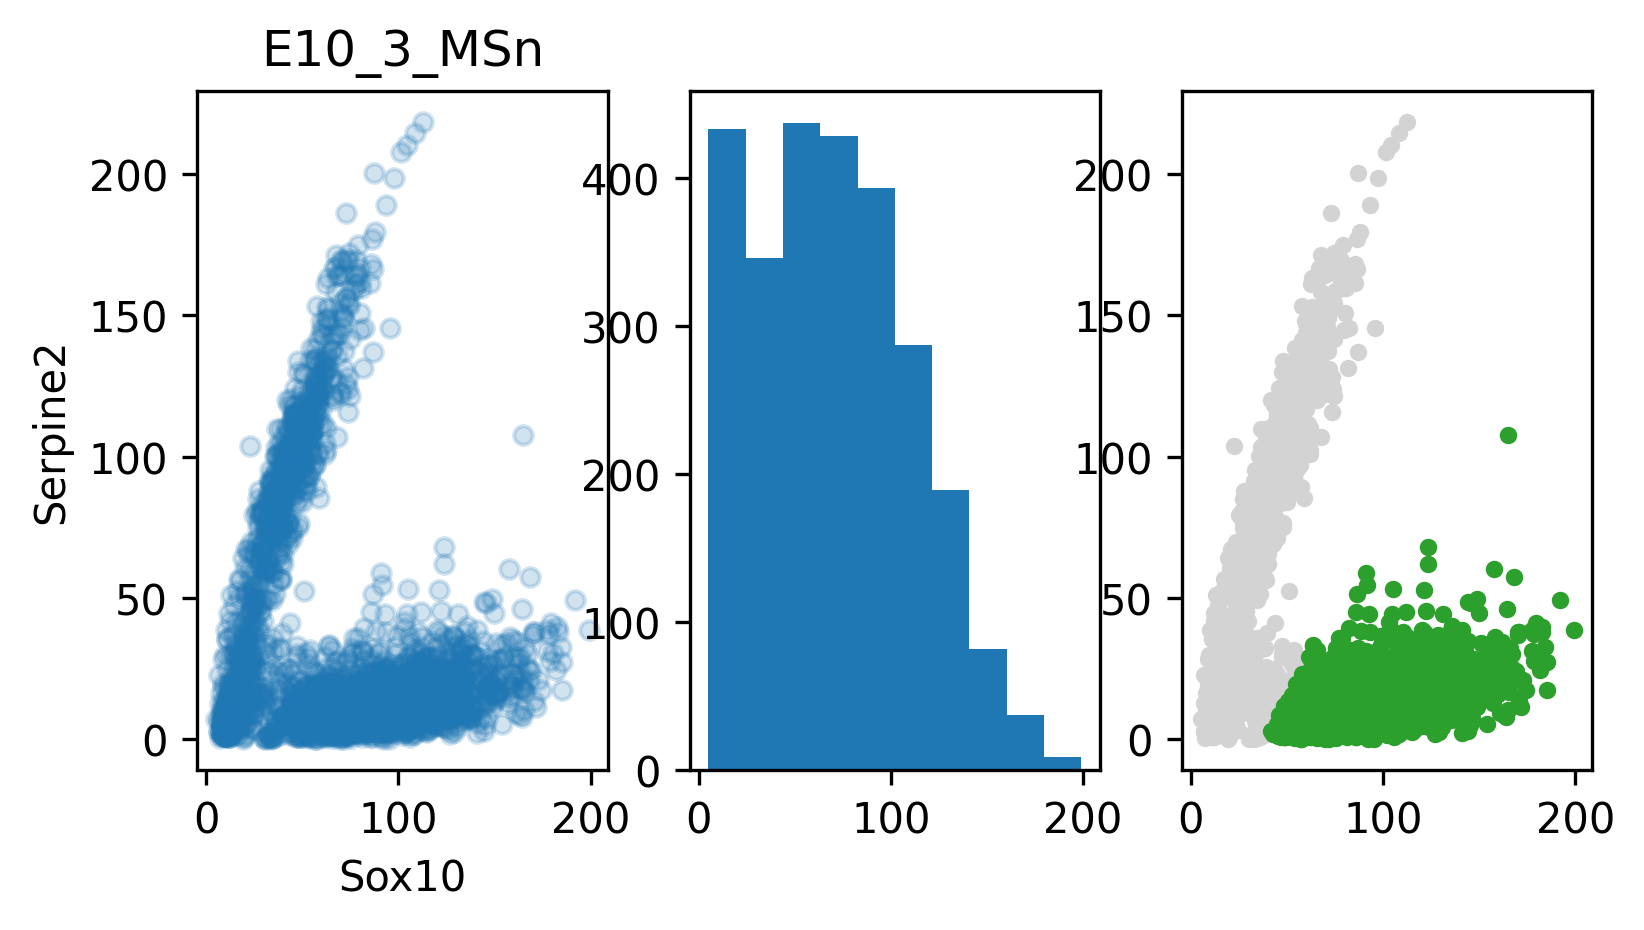

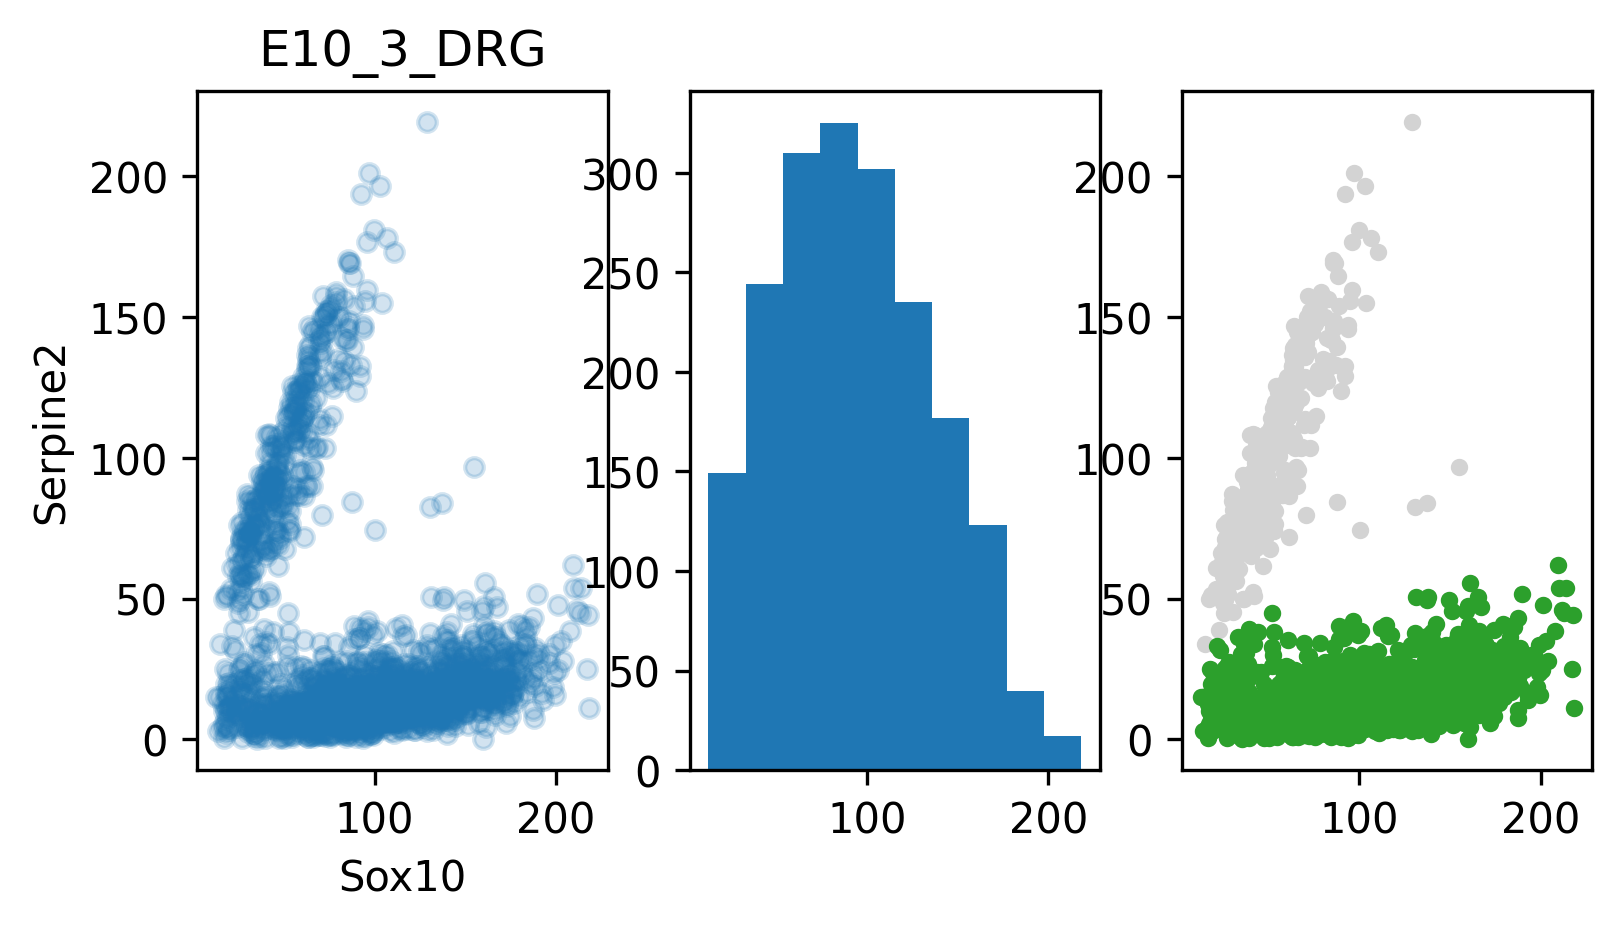

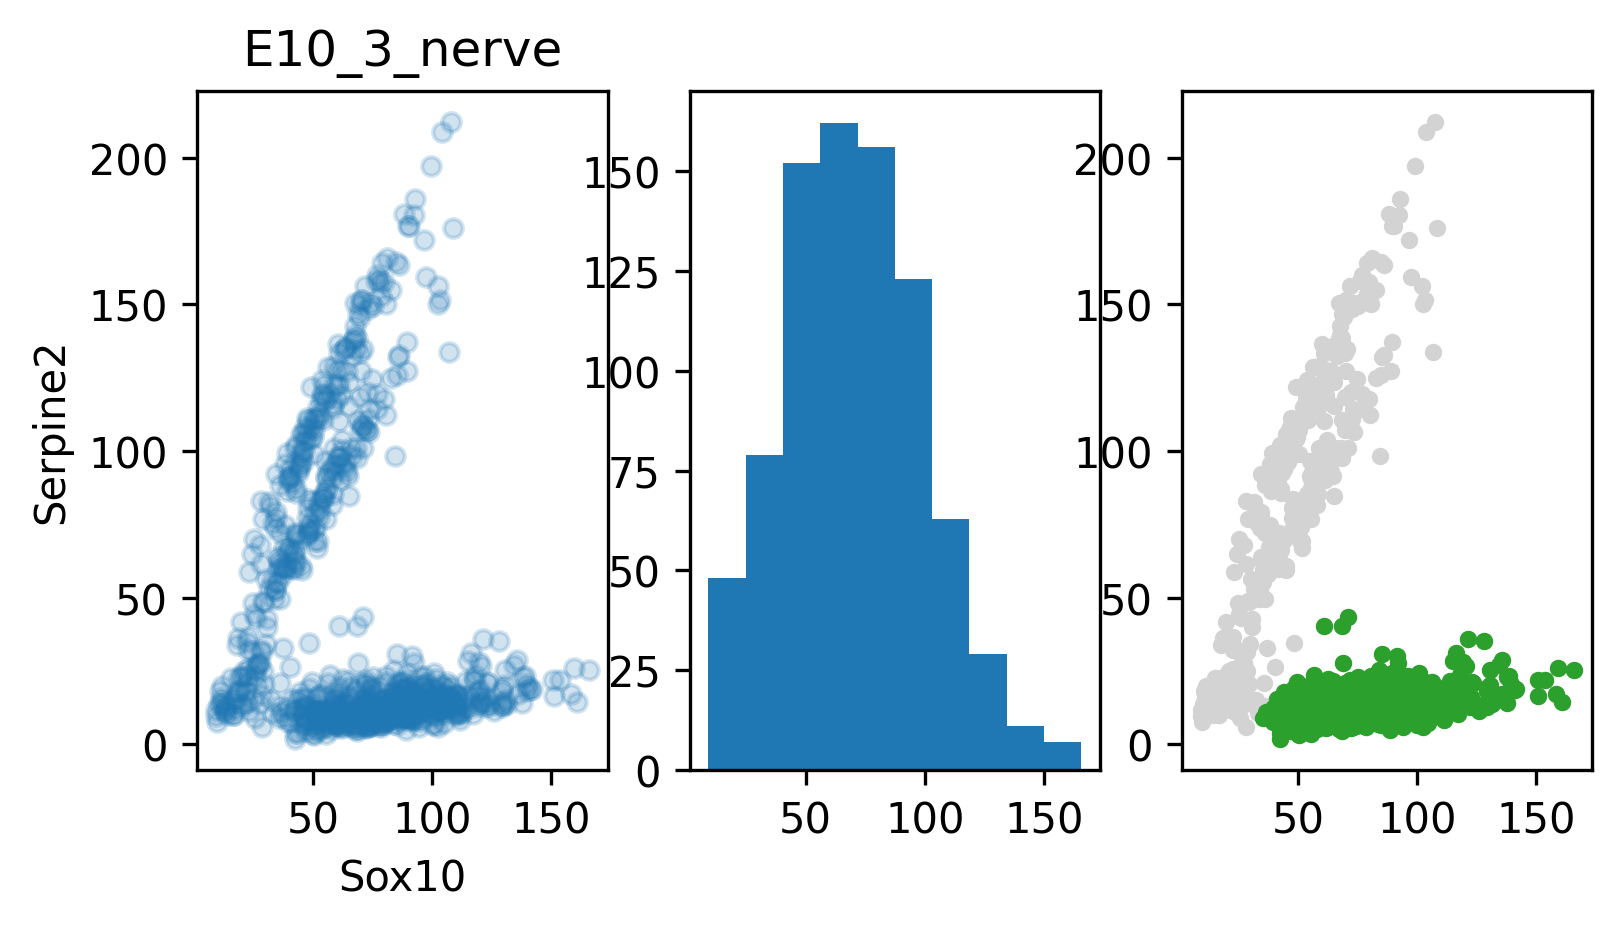

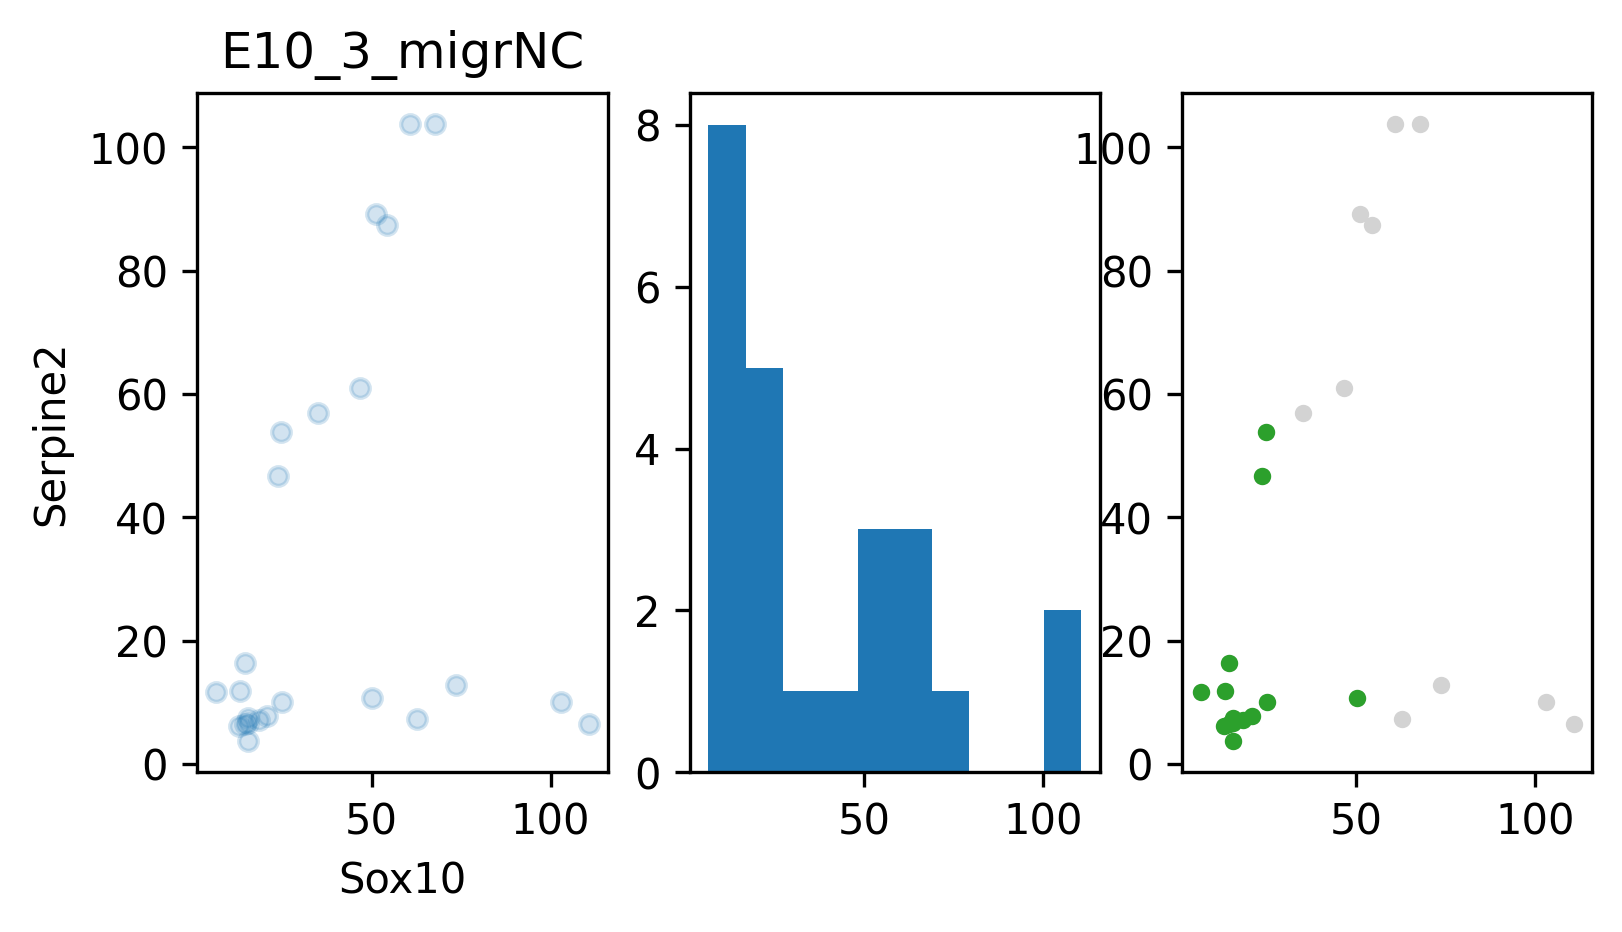

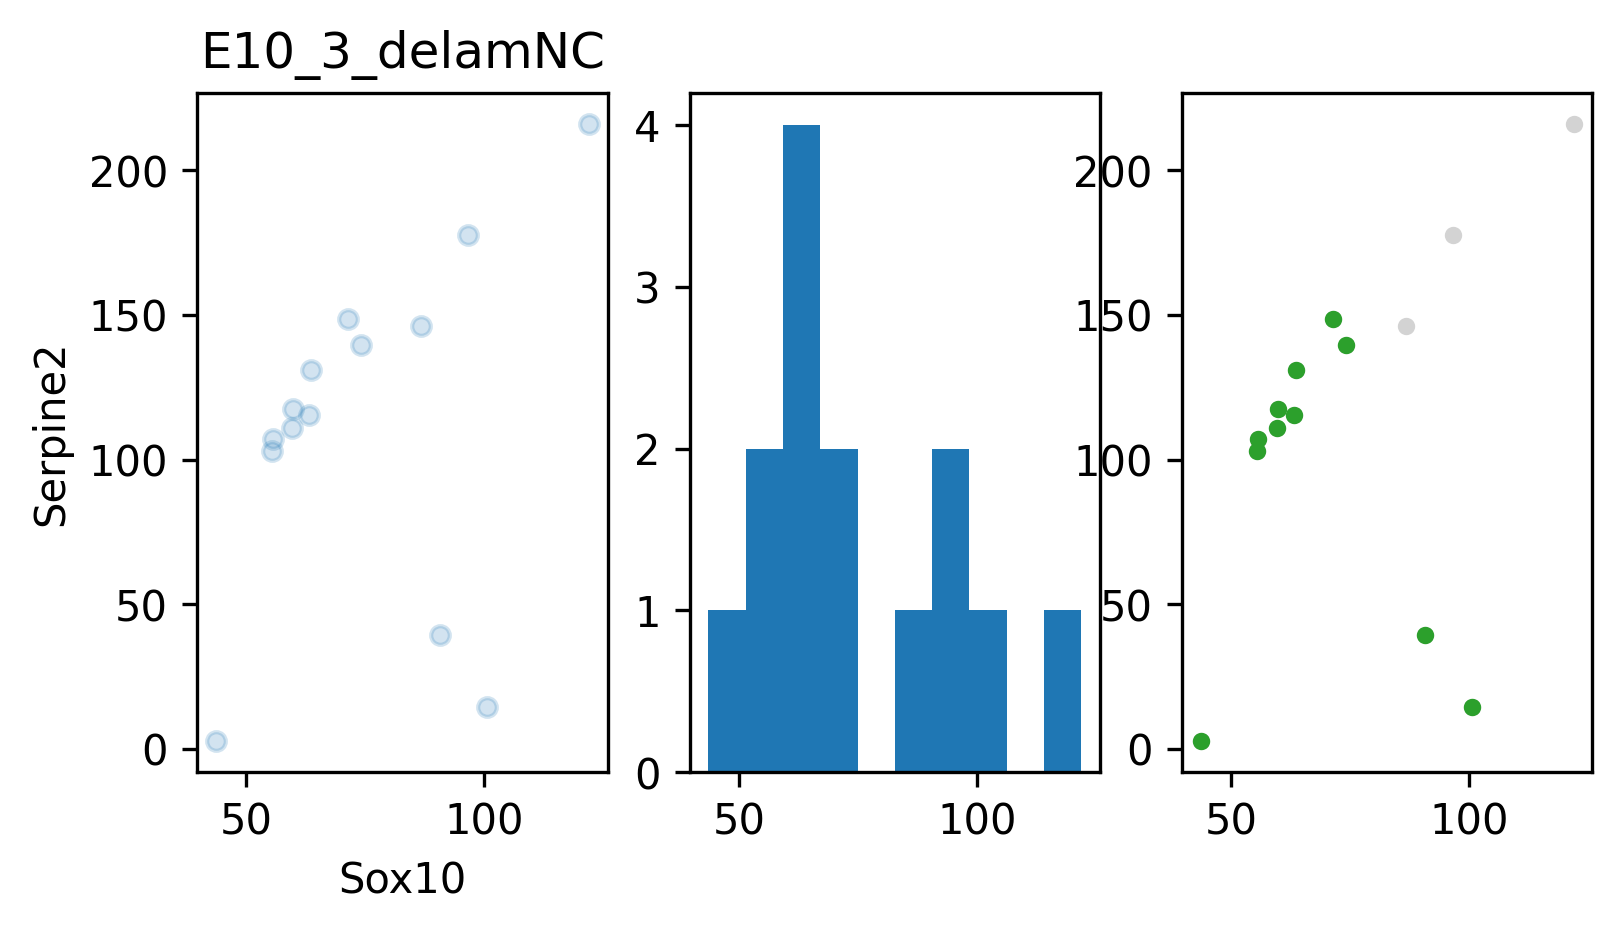

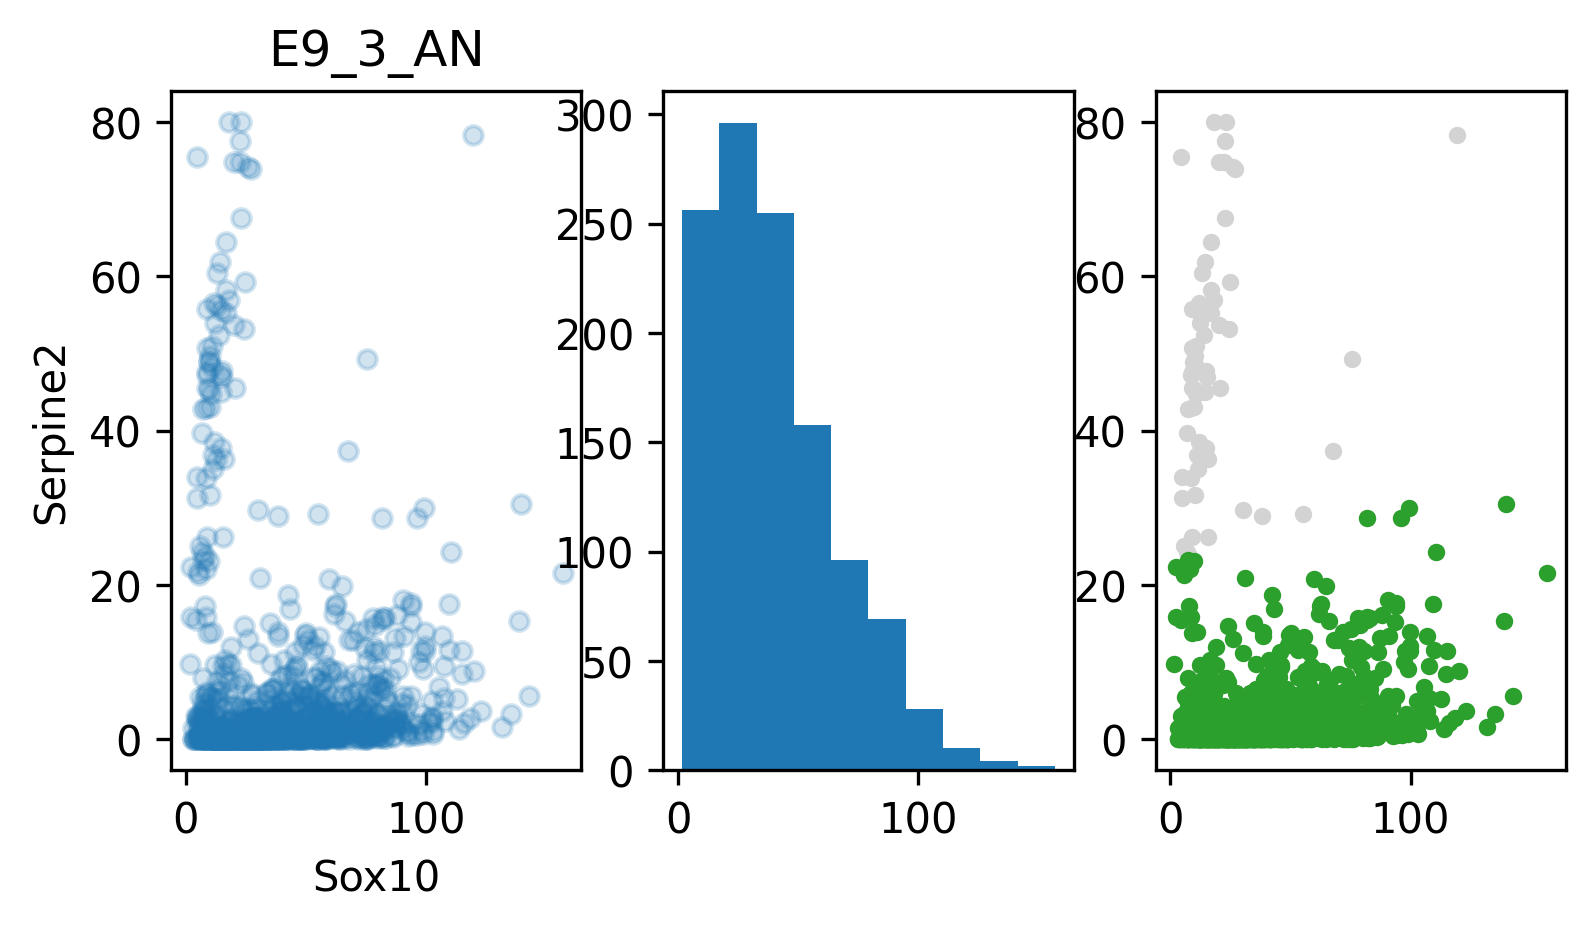

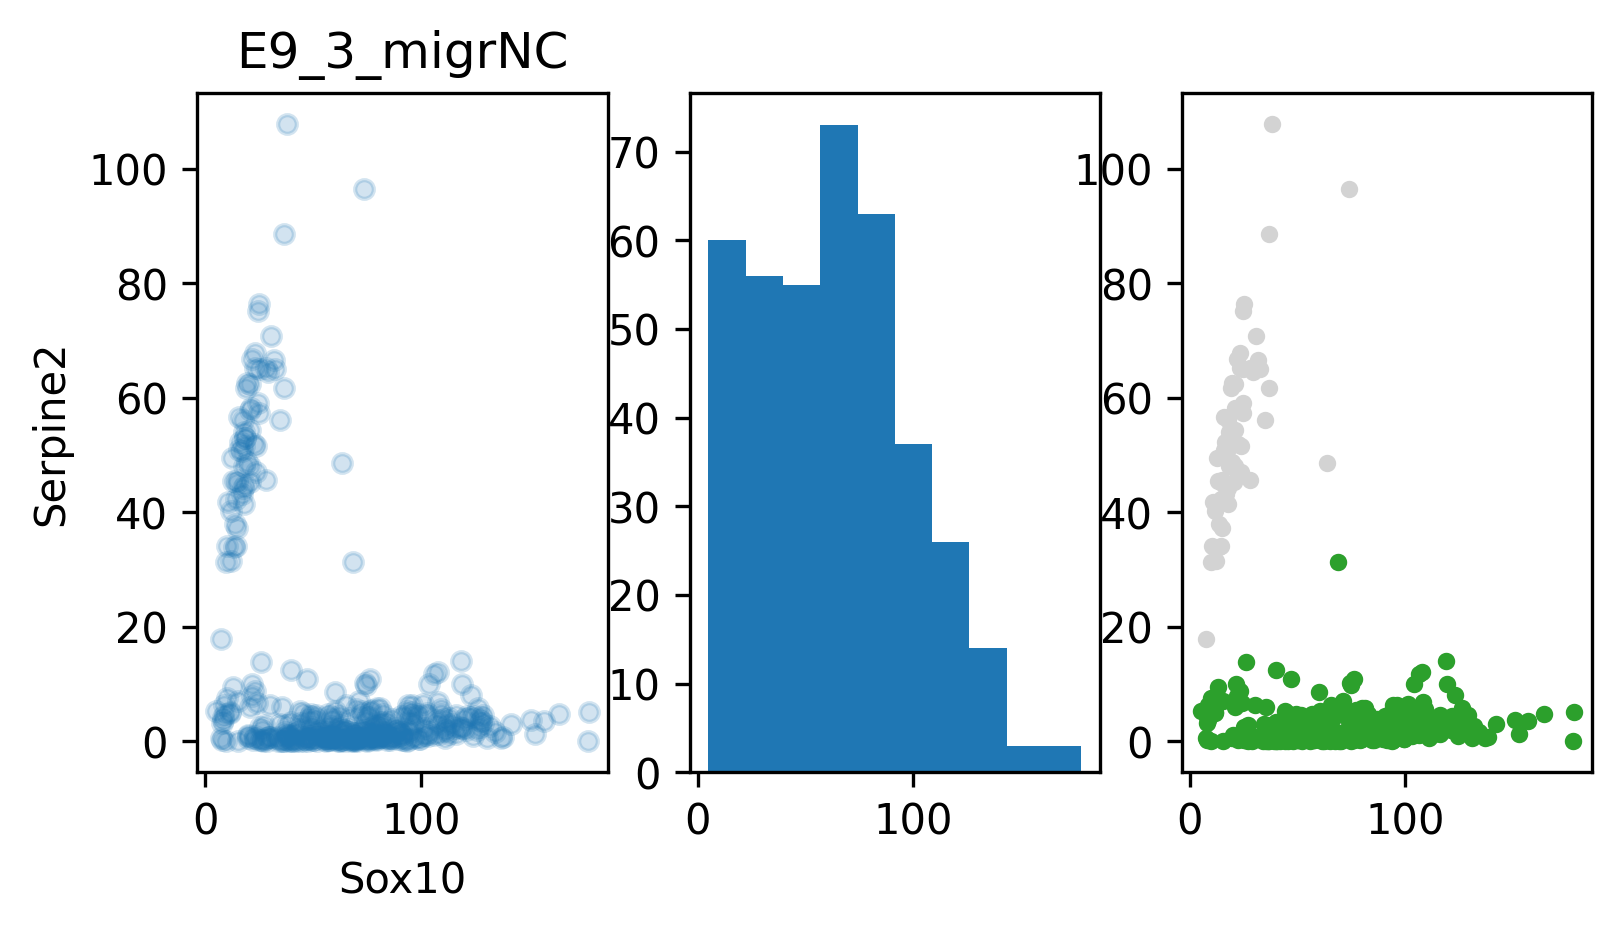

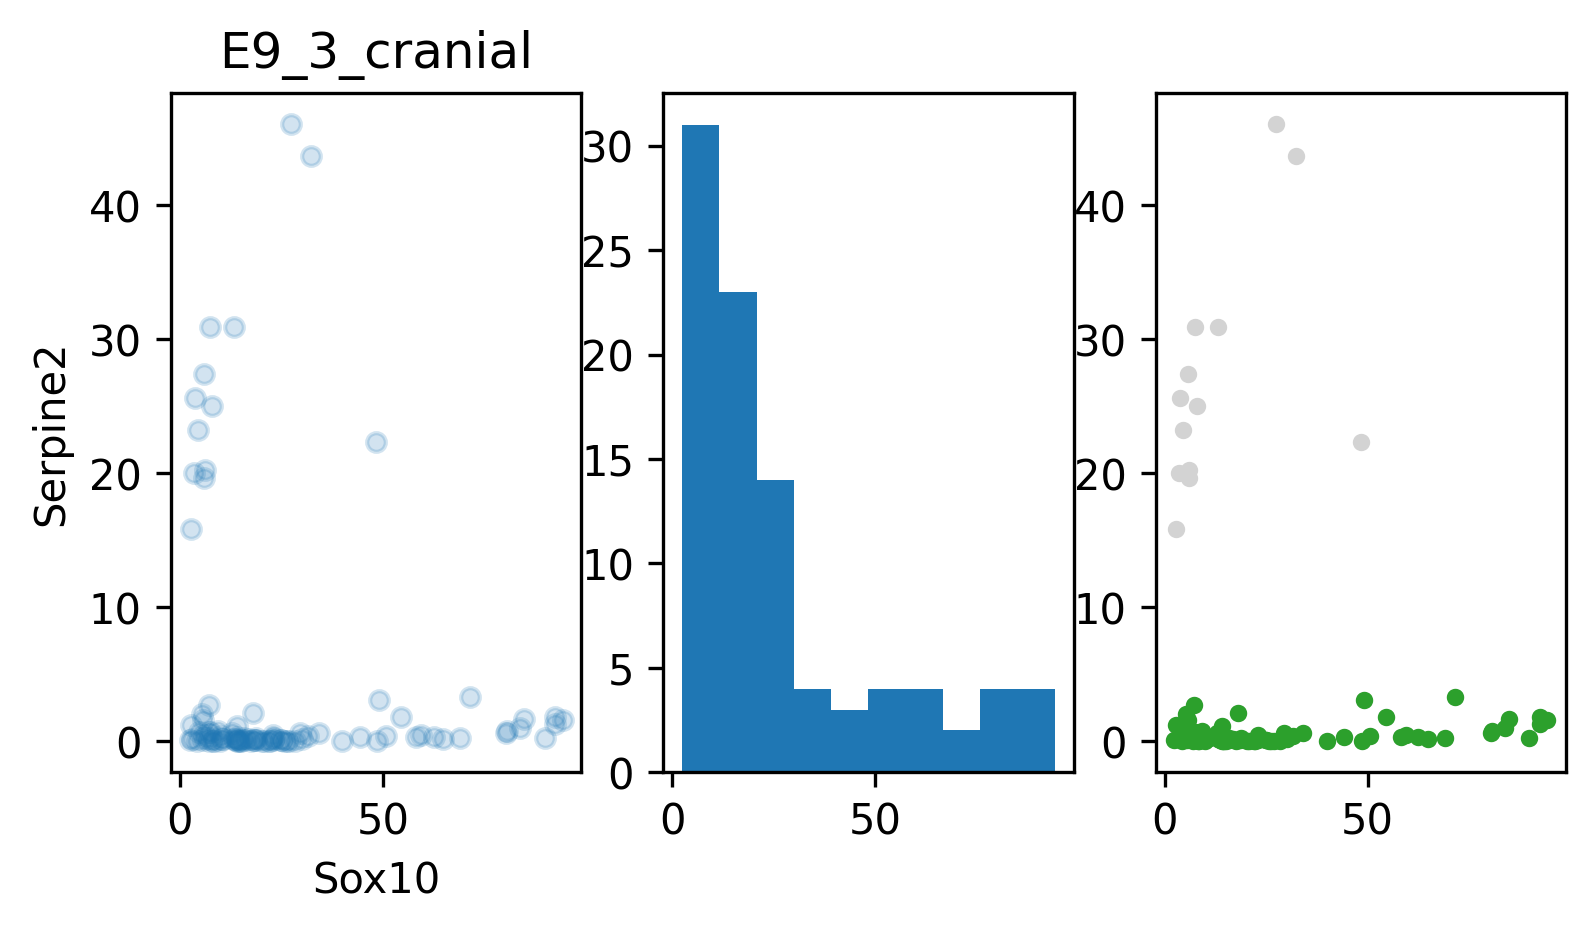

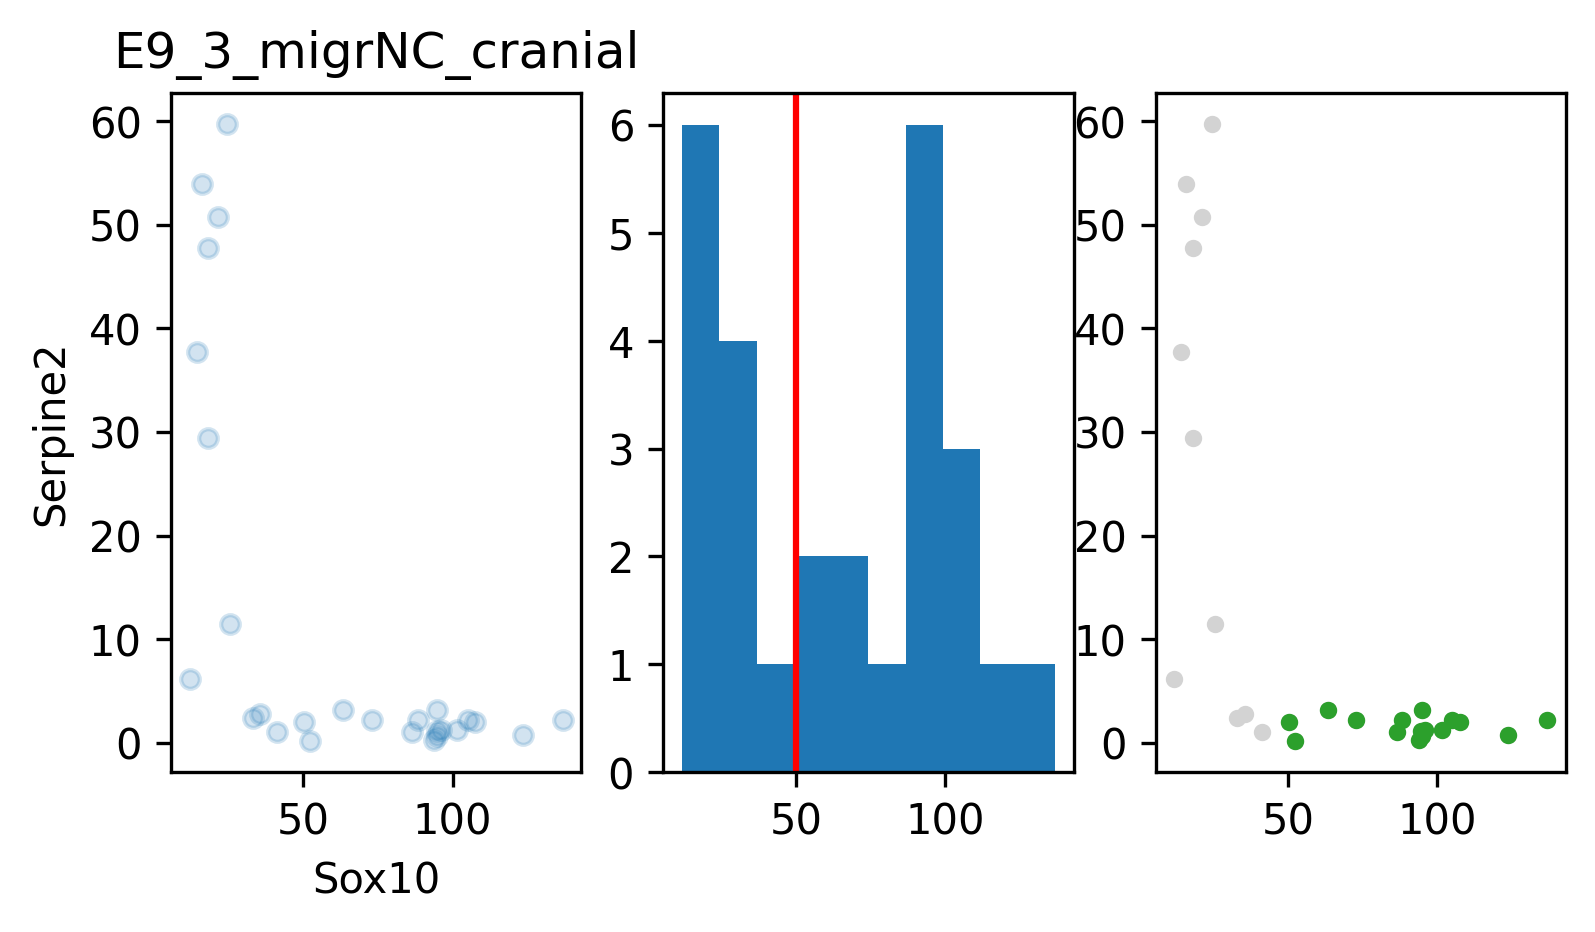

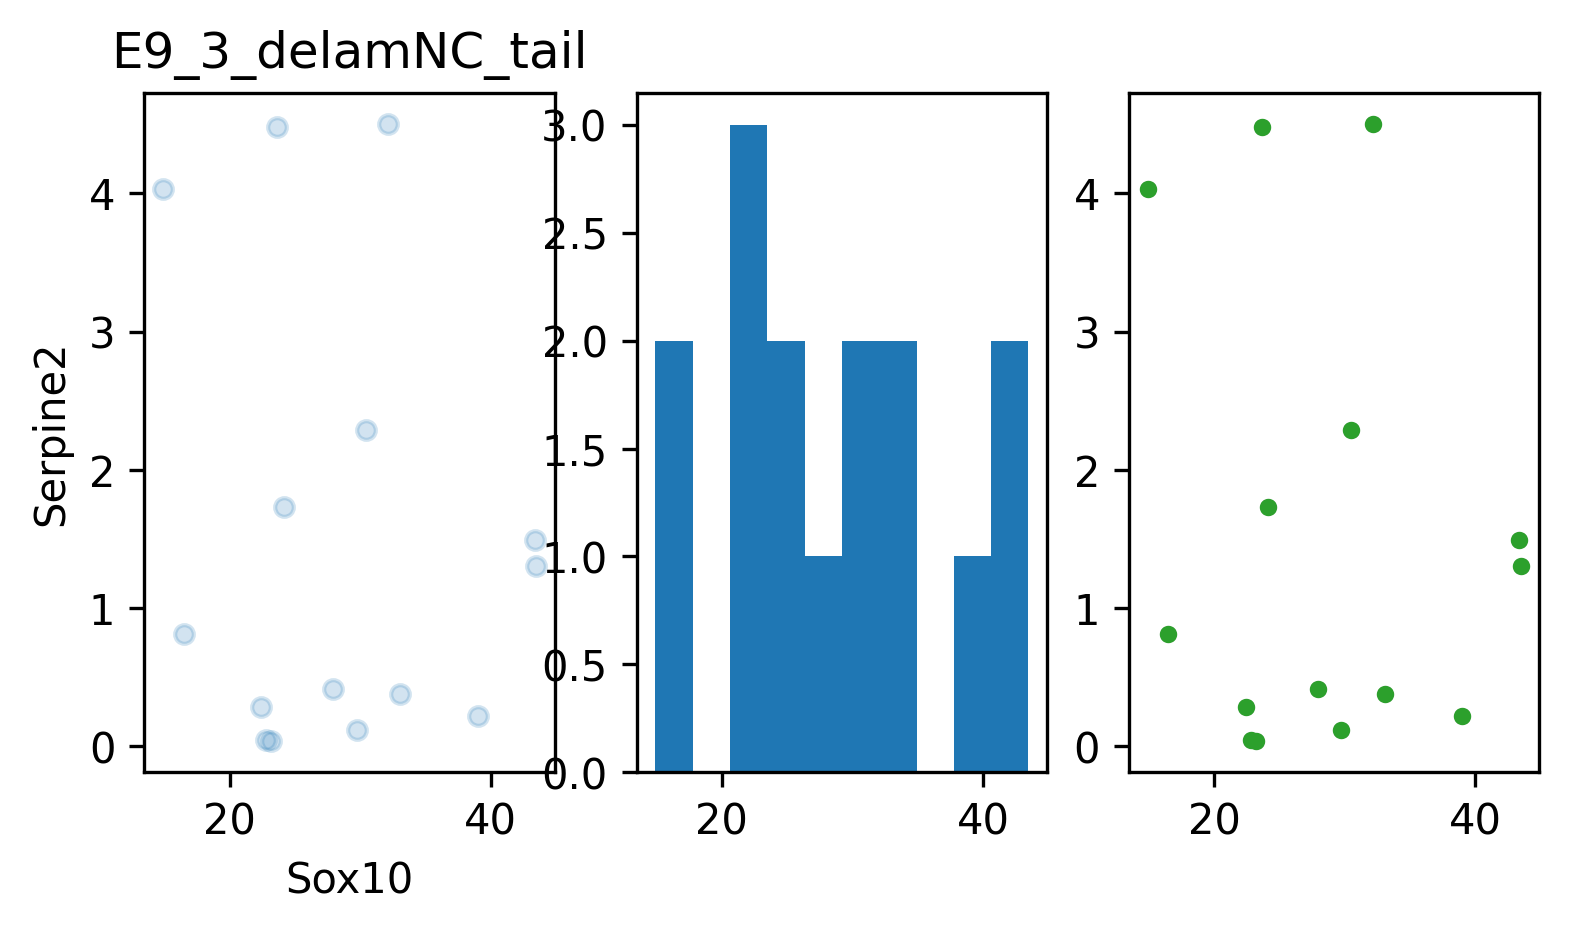

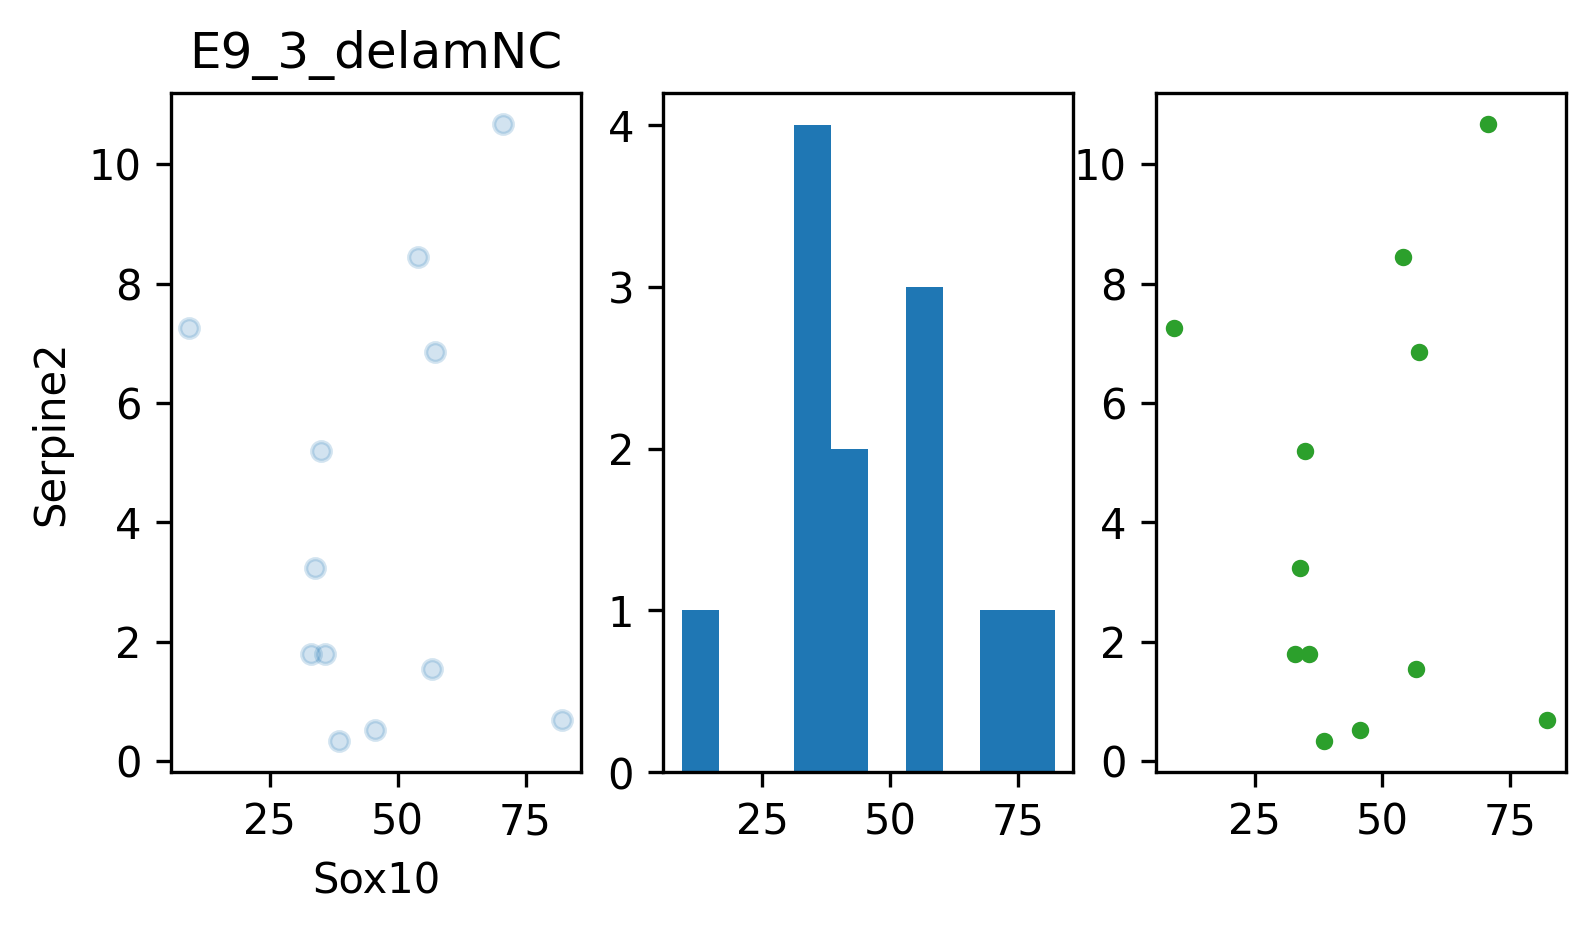

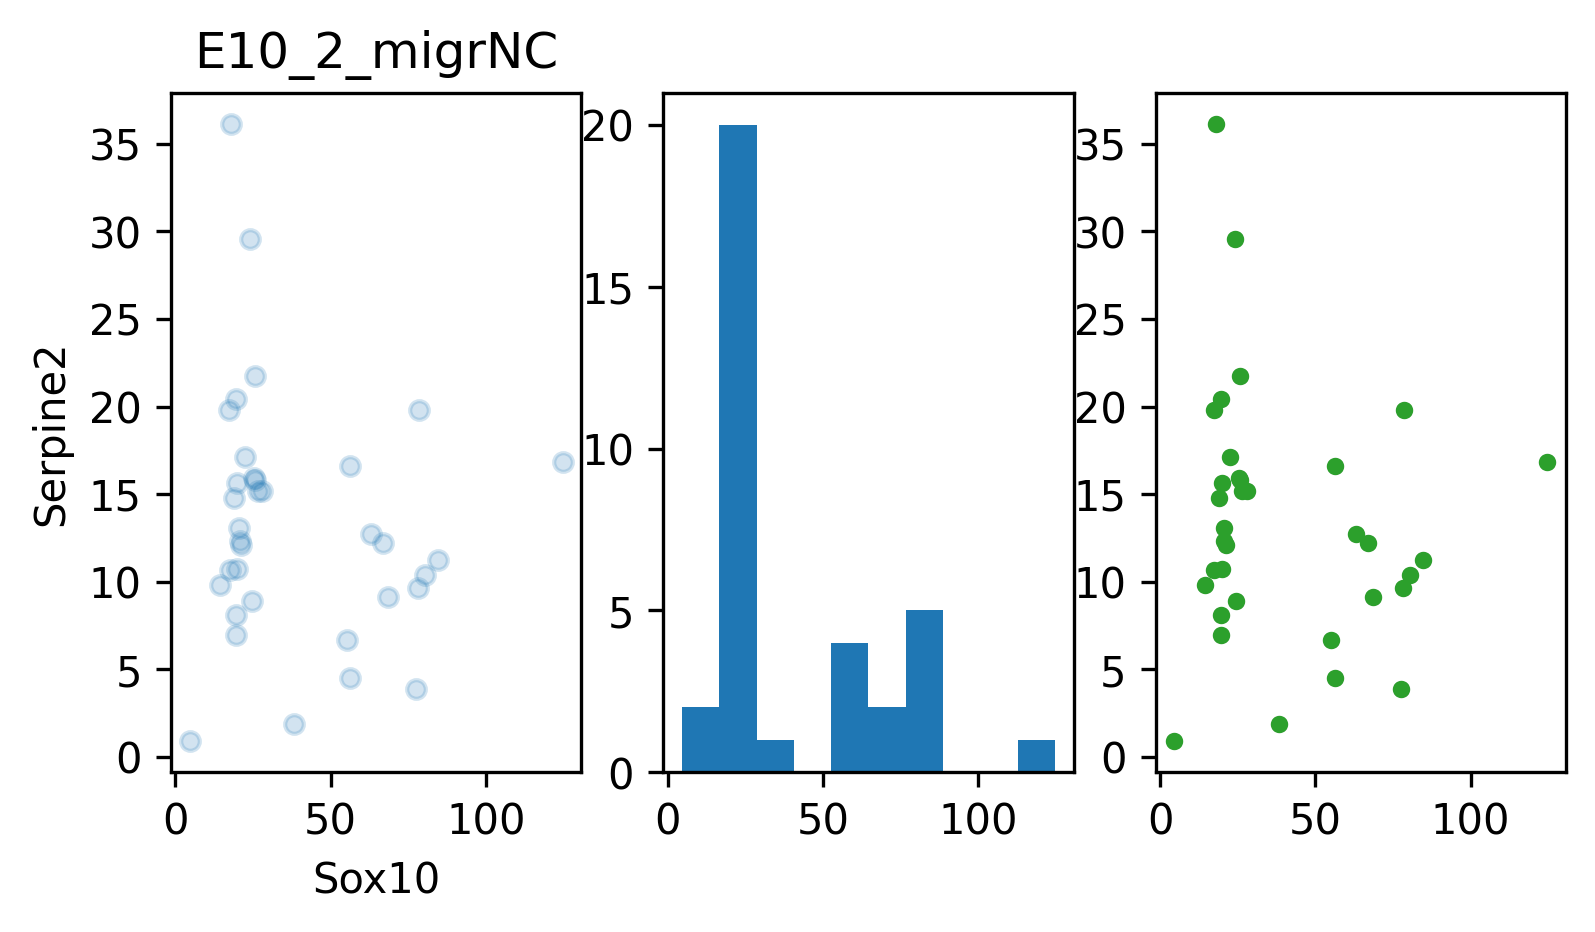

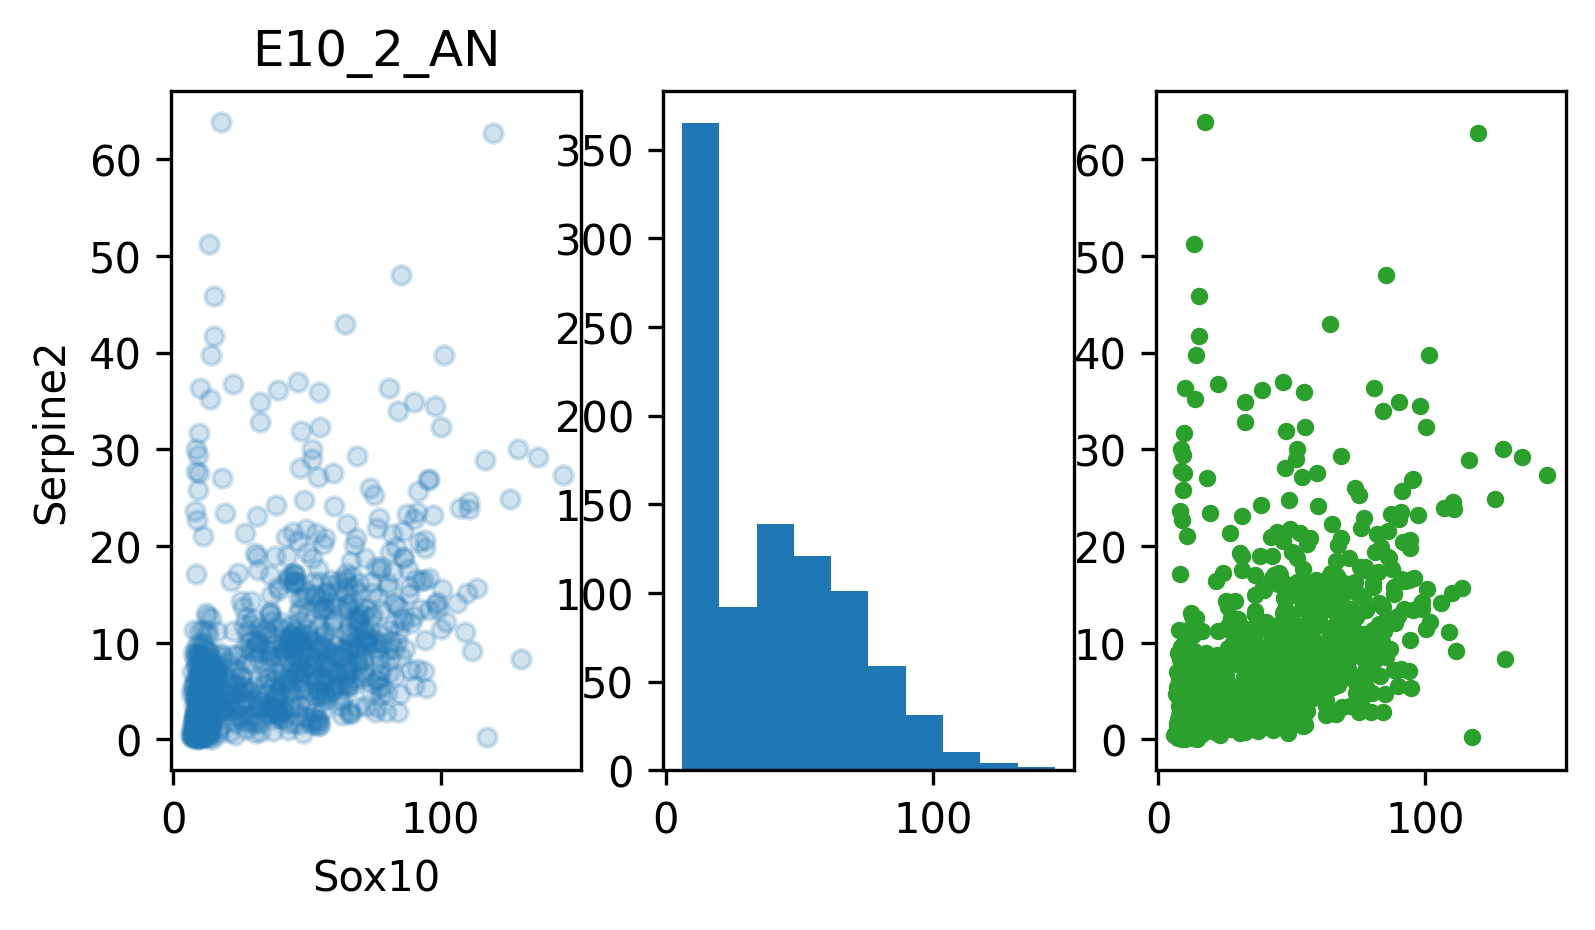

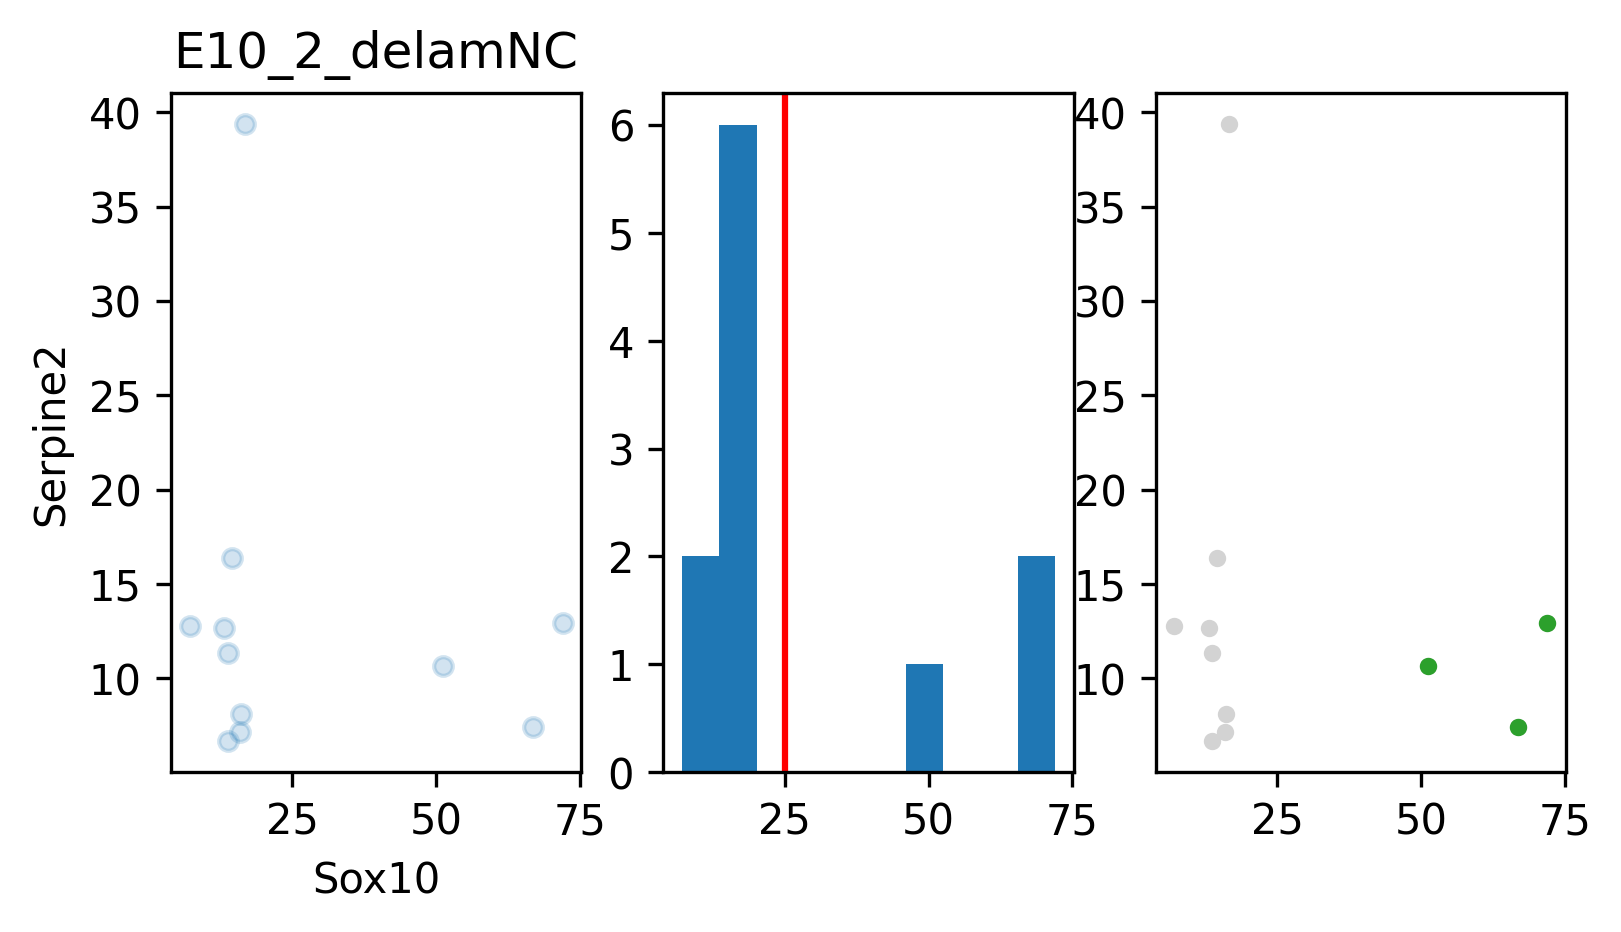

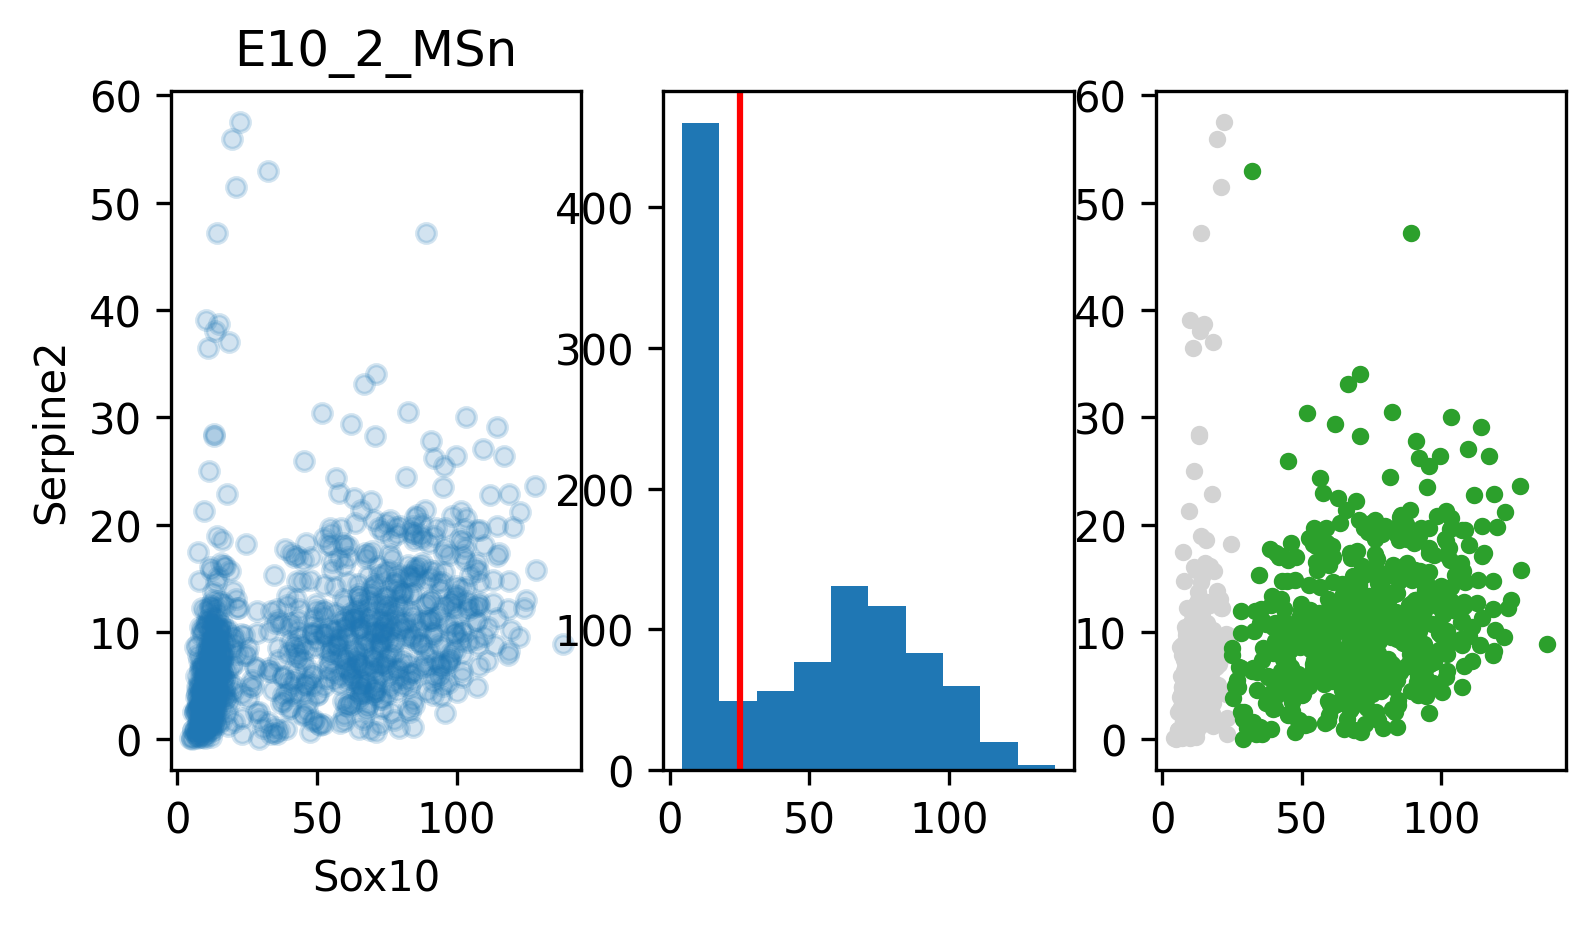

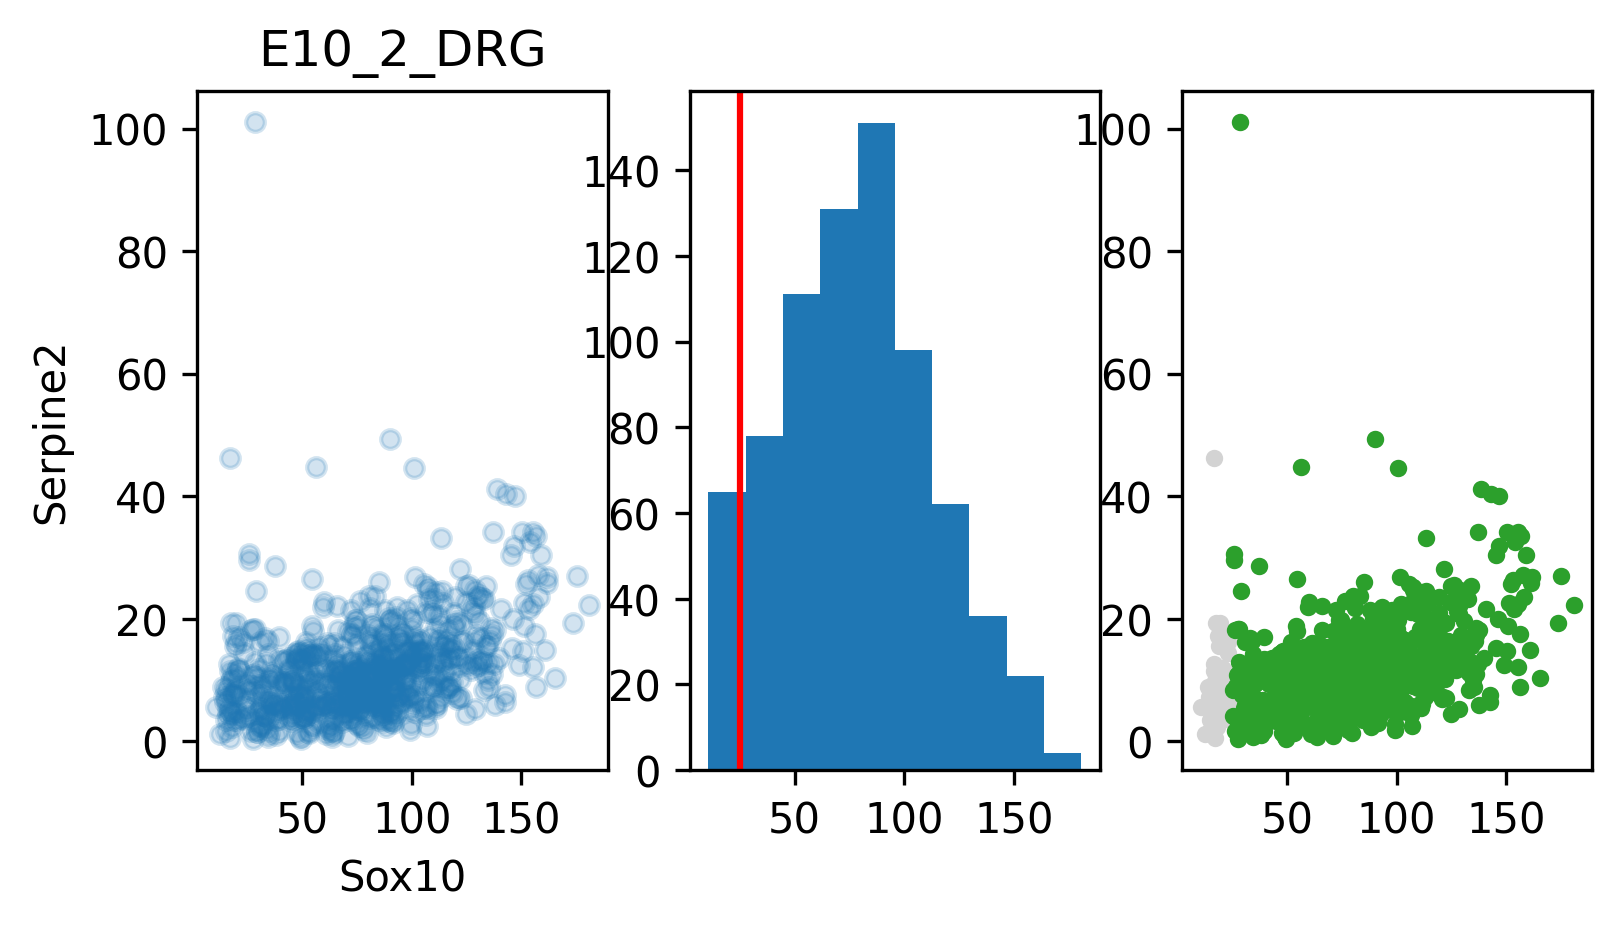

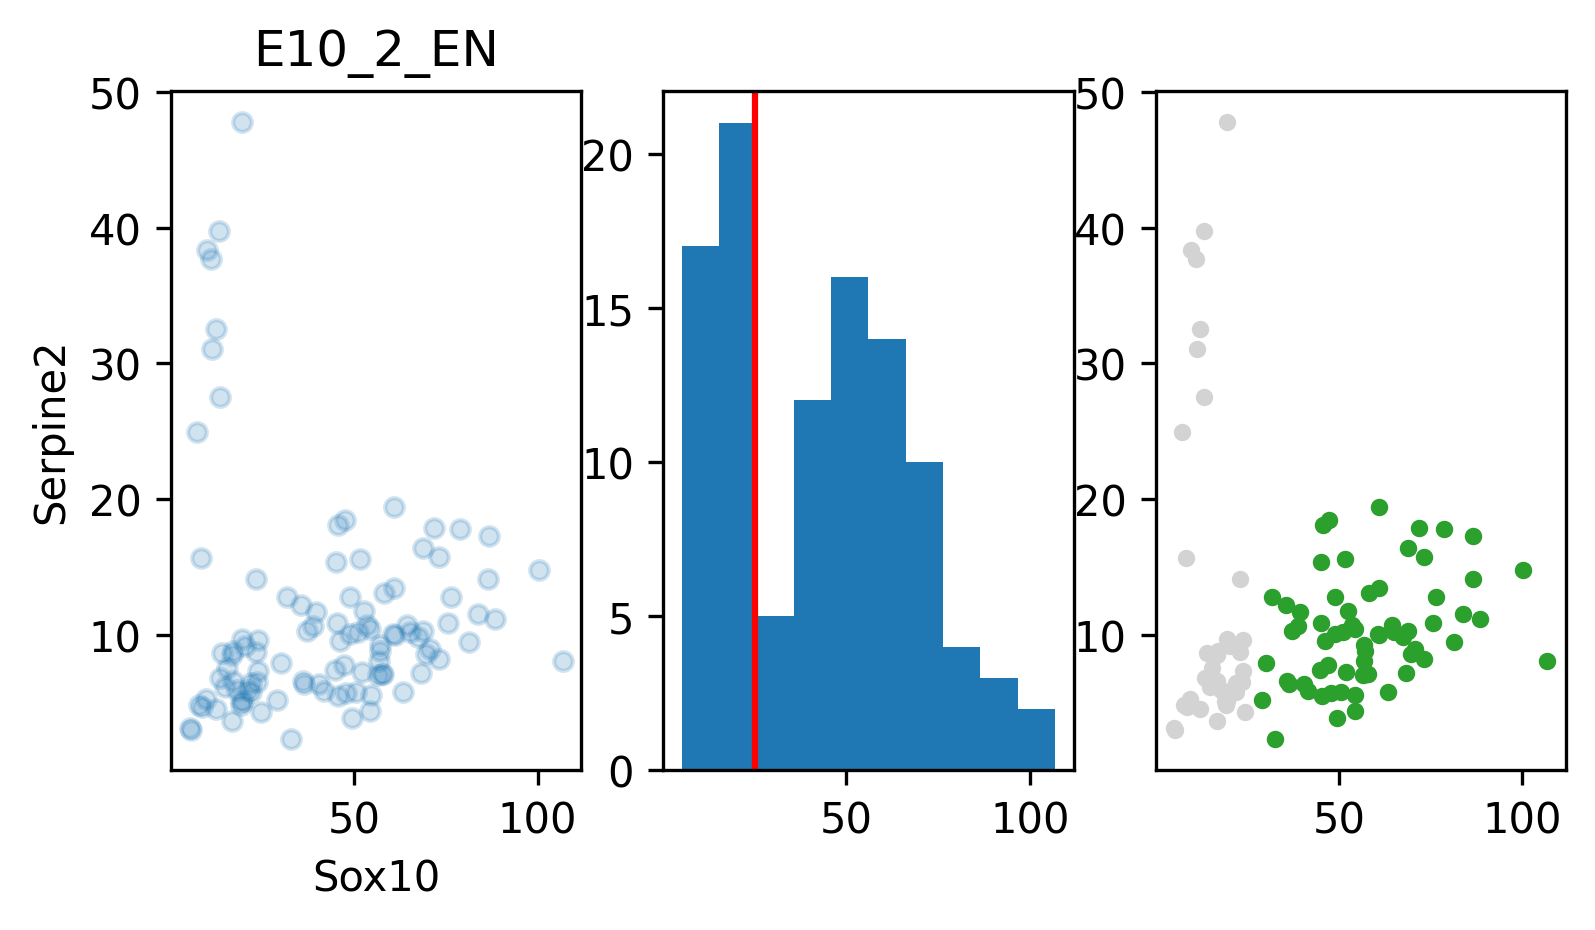

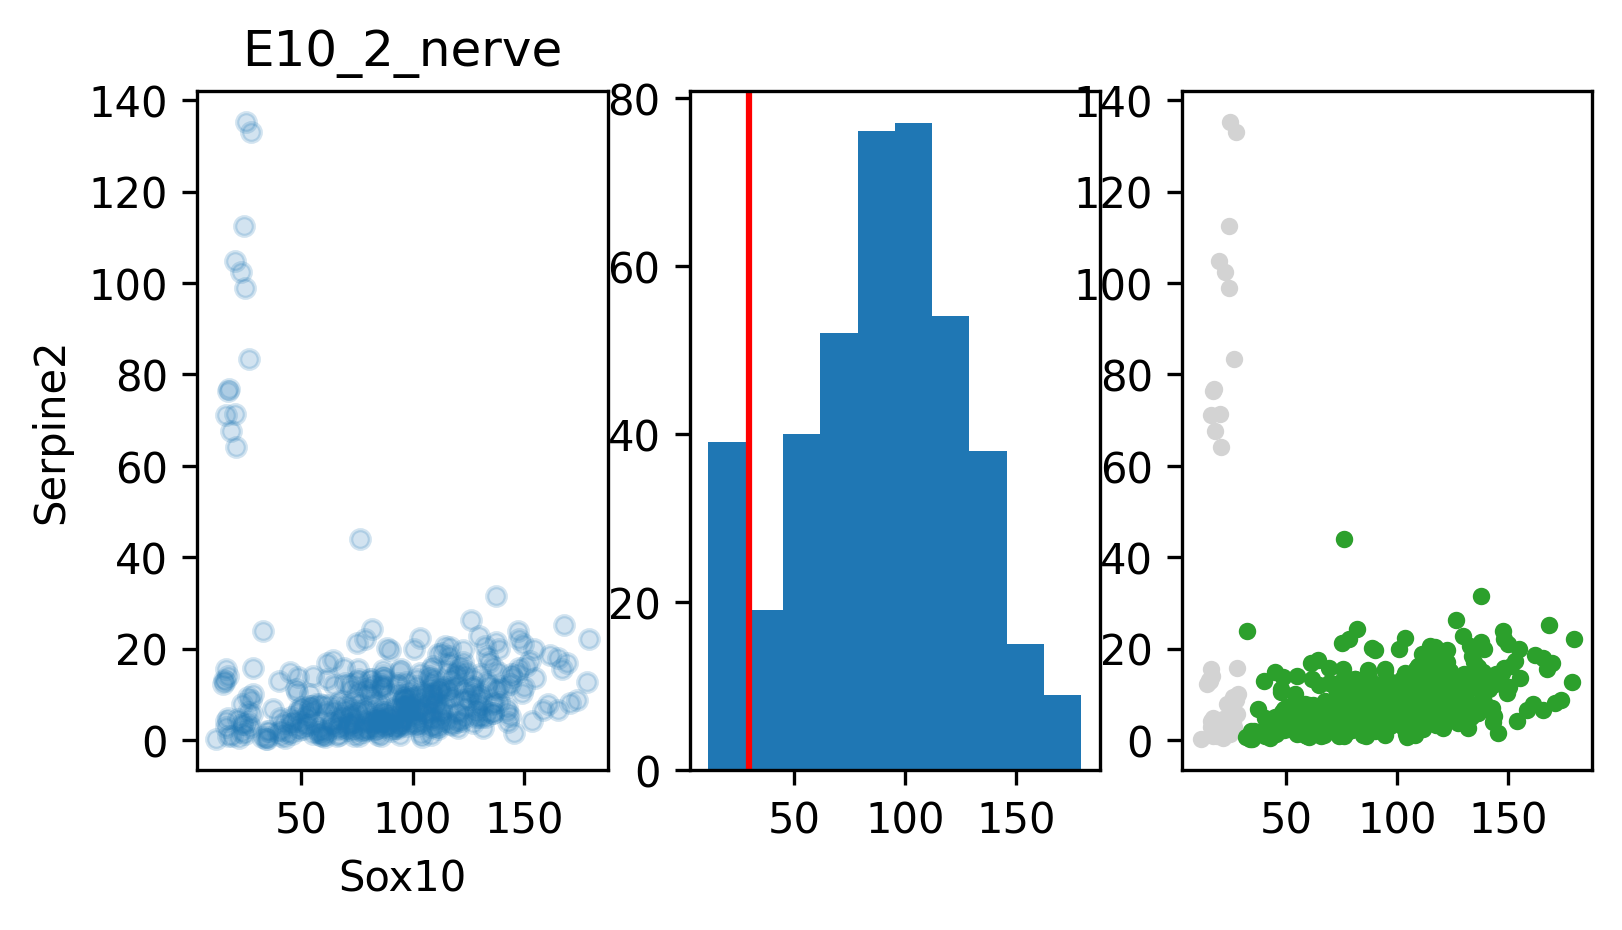

In [11]:
for i,(exp,df) in enumerate(data.items()):
    fig,axs=plt.subplots(1,3,figsize=(6,3))
    df.plot.scatter(x="Sox10",y=marker,title=exp,alpha=.2,ax=axs[0])
    axs[1].hist(df.Sox10)
    if clean[i]>1:
        data[exp]["keep"]=(df.Sox10>clean[i]).astype(str)
        axs[1].axvline(clean[i],color="red")
    elif clean[i]==1:
        filter_kmean(exp)
    else:
        data[exp]["keep"]="True"
    axs[2].scatter(data[exp].Sox10,data[exp][marker],c="lightgrey",s=10)
    axs[2].scatter(data[exp].Sox10[data[exp].keep=="True"],
                   data[exp][marker][data[exp].keep=="True"],
                   c="tab:green",s=10)

In [12]:
data["E10_3_delamNC"]=data["E10_3_delamNC"].loc[data["E10_3_delamNC"]["Serpine2"]<50]
alldata=pd.concat([pd.DataFrame({exp:data[exp].loc[data[exp].keep=="True"][marker]}).melt() for exp in data.keys()])

In [13]:
alldata.columns=["loc",marker]

In [14]:
alldata["loc"]=alldata["loc"].astype("category")

In [15]:
alldata["loc"]=alldata["loc"].cat.reorder_categories(alldata["loc"].cat.categories[19:].tolist()+alldata["loc"].cat.categories[:19].tolist())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 [Text(0, 0, 'E9_2_AN'),
  Text(1, 0, 'E9_2_DRG'),
  Text(2, 0, 'E9_2_MSn'),
  Text(3, 0, 'E9_2_Msn'),
  Text(4, 0, 'E9_2_delamNC'),
  Text(5, 0, 'E9_2_migrNC'),
  Text(6, 0, 'E9_3_AN'),
  Text(7, 0, 'E9_3_cranial'),
  Text(8, 0, 'E9_3_delamNC'),
  Text(9, 0, 'E9_3_delamNC_tail'),
  Text(10, 0, 'E9_3_migrNC'),
  Text(11, 0, 'E9_3_migrNC_cranial'),
  Text(12, 0, 'E10_2_AN'),
  Text(13, 0, 'E10_2_DRG'),
  Text(14, 0, 'E10_2_EN'),
  Text(15, 0, 'E10_2_MSn'),
  Text(16, 0, 'E10_2_delamNC'),
  Text(17, 0, 'E10_2_migrNC'),
  Text(18, 0, 'E10_2_nerve'),
  Text(19, 0, 'E10_3_AN'),
  Text(20, 0, 'E10_3_DRG'),
  Text(21, 0, 'E10_3_EN'),
  Text(22, 0, 'E10_3_MSn'),
  Text(23, 0, 'E10_3_delamNC'),
  Text(24, 0, 'E10_3_migrNC'),
  Text(25, 0, 'E10_3_nerve'),
  Text(26, 0, 'E11_2_AN'),
  Text(27, 0, 'E11_2_DRG'),
  Text(28, 0, 'E11_2_EN'),
  Text(29, 0, 'E11_2

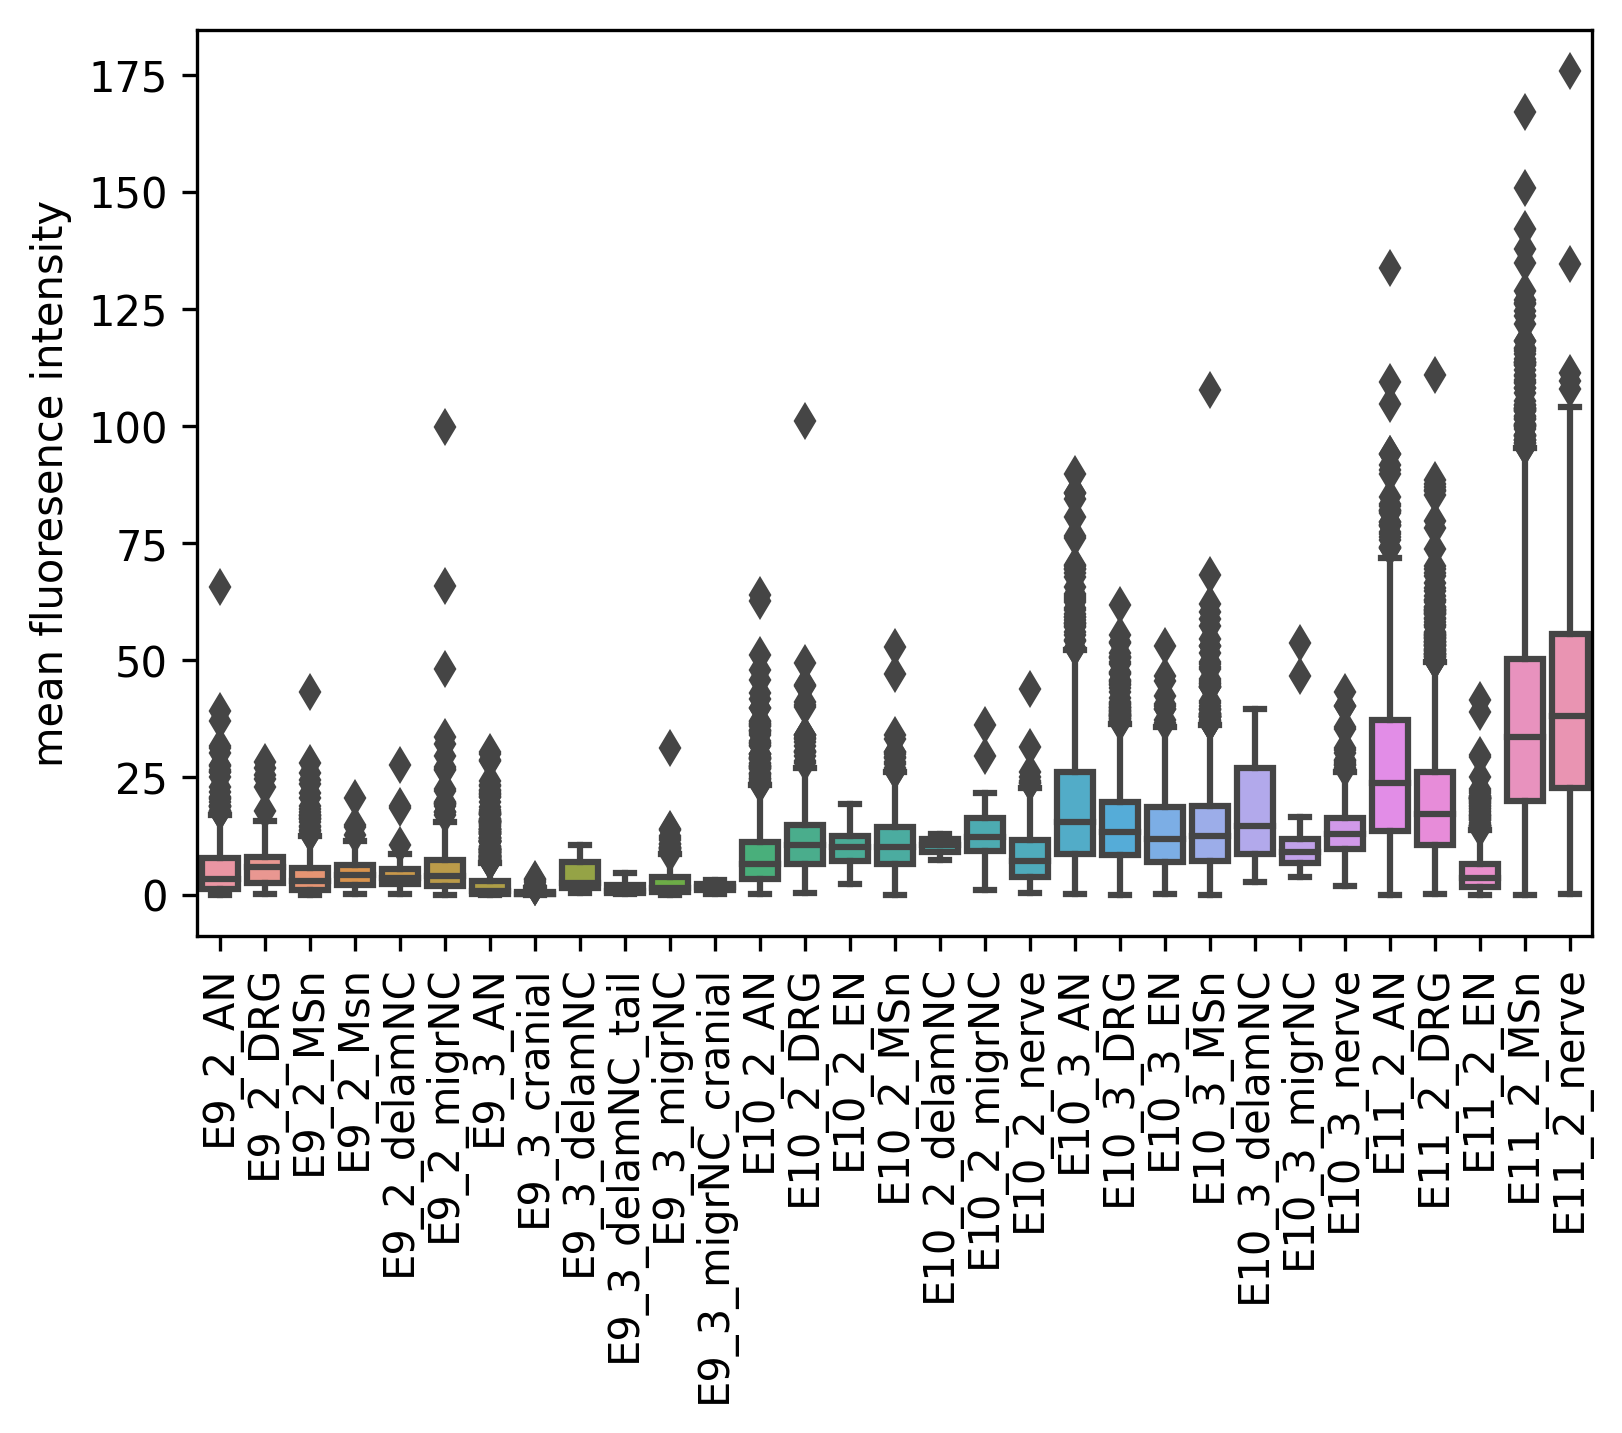

In [16]:
import seaborn as sns
sns.boxplot(x="loc",y=marker,data=alldata)
plt.ylabel("mean fluoresence intensity")
plt.xlabel("")
plt.xticks(rotation=90)

In [17]:
alldata["locations"]=["_".join([l.split("_")[i] for i in [0,2]]) for l in alldata["loc"].values]

In [18]:
alldata["locations"]=alldata["locations"].astype("category")

In [19]:
alldata.locations=alldata.locations.cat.reorder_categories(alldata.locations.cat.categories[12:].tolist()+alldata.locations.cat.categories[:12].tolist())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'E9_AN'),
  Text(1, 0, 'E9_DRG'),
  Text(2, 0, 'E9_MSn'),
  Text(3, 0, 'E9_Msn'),
  Text(4, 0, 'E9_cranial'),
  Text(5, 0, 'E9_delamNC'),
  Text(6, 0, 'E9_migrNC'),
  Text(7, 0, 'E10_AN'),
  Text(8, 0, 'E10_DRG'),
  Text(9, 0, 'E10_EN'),
  Text(10, 0, 'E10_MSn'),
  Text(11, 0, 'E10_delamNC'),
  Text(12, 0, 'E10_migrNC'),
  Text(13, 0, 'E10_nerve'),
  Text(14, 0, 'E11_AN'),
  Text(15, 0, 'E11_DRG'),
  Text(16, 0, 'E11_EN'),
  Text(17, 0, 'E11_MSn'),
  Text(18, 0, 'E11_nerve')])

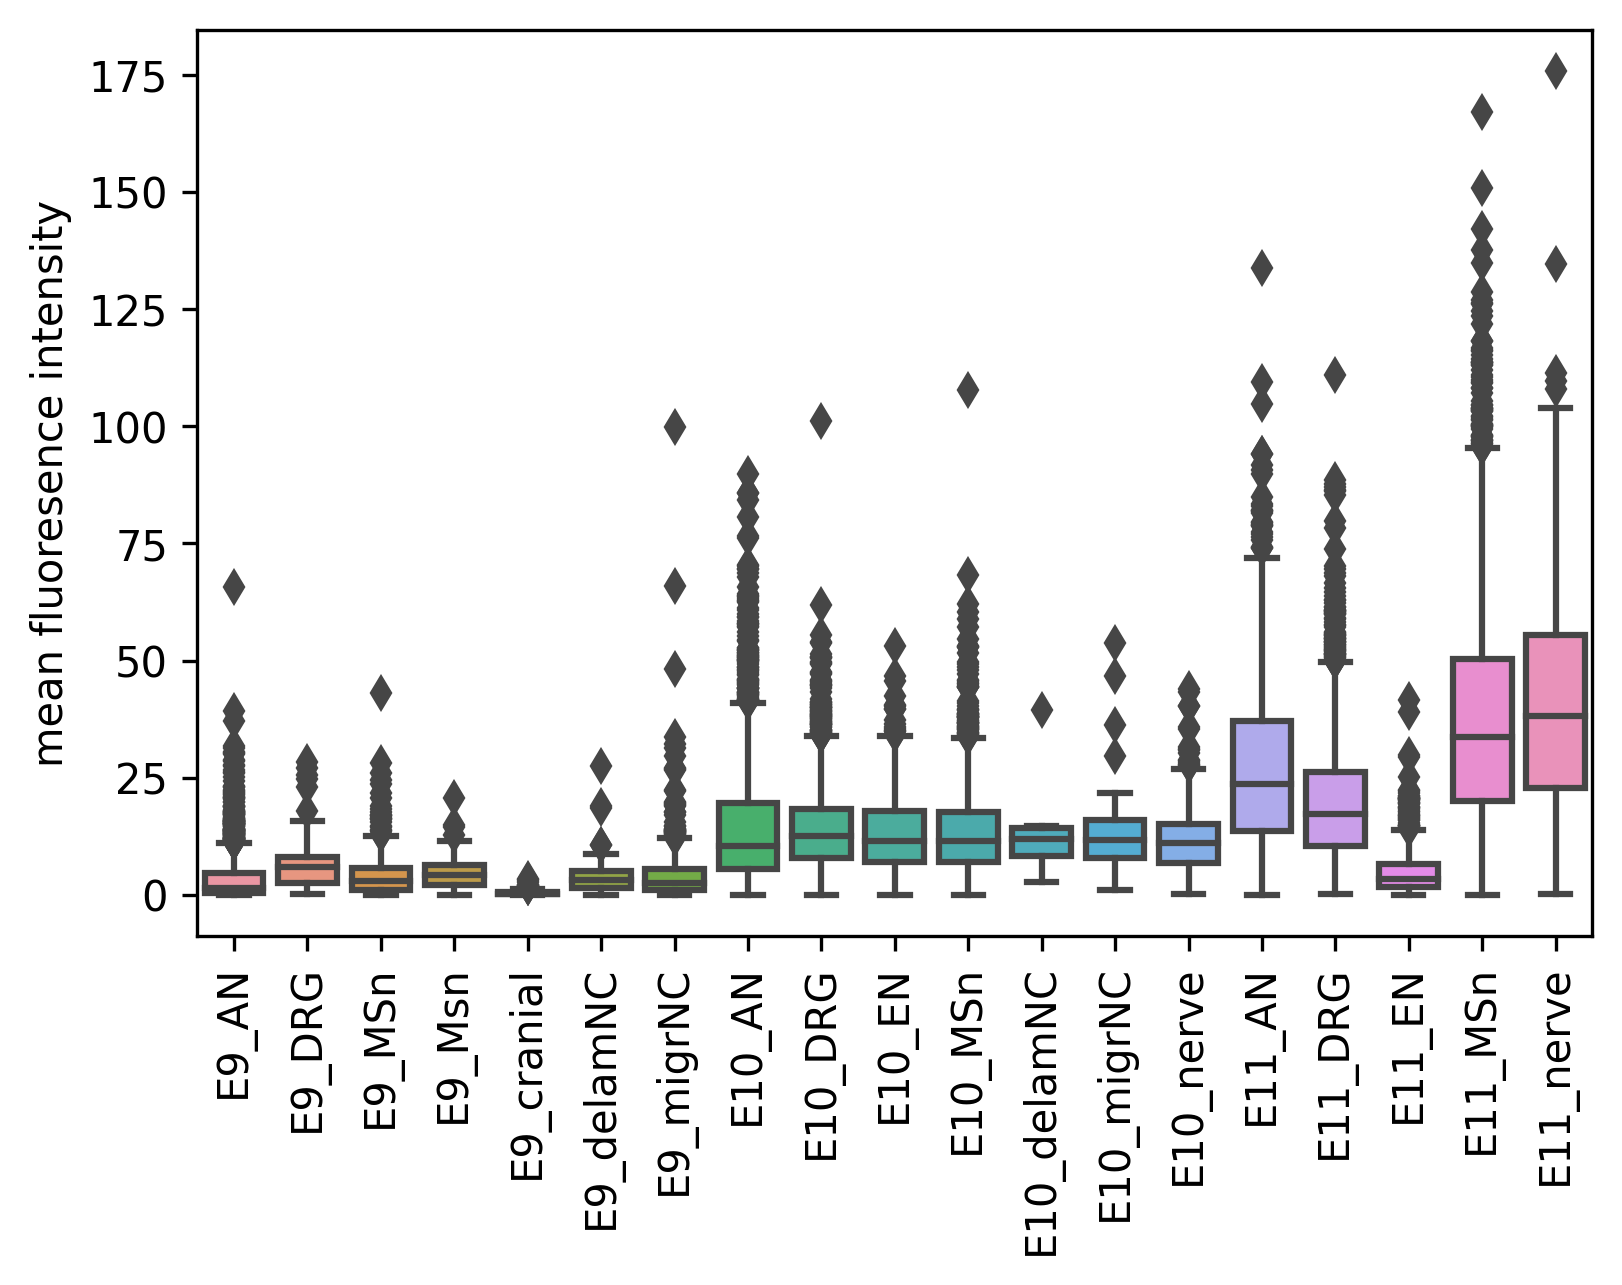

In [20]:
import seaborn as sns
sns.boxplot(x="locations",y=marker,data=alldata)
plt.ylabel("mean fluoresence intensity")
plt.xlabel("")
plt.xticks(rotation=90)

In [21]:
alldata["location"]=alldata["locations"].str.split("_").str[1]
alldata["devtime"]=alldata["locations"].str.split("_").str[0]

In [22]:
alldata["devtime"]=alldata["devtime"].astype("category")
alldata["devtime"]=alldata["devtime"].cat.reorder_categories(["E9","E10","E11"])

In [23]:
alldata["location"]=alldata["location"].replace("Msn","MSn")

In [24]:
alldata

loc   Serpine2  locations location devtime
0       E11_2_EN  19.660066     E11_EN       EN     E11
1       E11_2_EN  29.399240     E11_EN       EN     E11
2       E11_2_EN  39.073746     E11_EN       EN     E11
3       E11_2_EN   3.019417     E11_EN       EN     E11
4       E11_2_EN   5.637838     E11_EN       EN     E11
..           ...        ...        ...      ...     ...
375  E10_2_nerve   7.744125  E10_nerve    nerve     E10
376  E10_2_nerve   6.125749  E10_nerve    nerve     E10
377  E10_2_nerve   6.556863  E10_nerve    nerve     E10
378  E10_2_nerve  13.314410  E10_nerve    nerve     E10
379  E10_2_nerve   9.122642  E10_nerve    nerve     E10

[21425 rows x 5 columns]

In [25]:
import scanpy as sc
alldata.index=alldata.index.astype(str)
adata=sc.AnnData(alldata[["Serpine2"]],obs=alldata)
adata.obs_names_make_unique()
del adata.obs["Serpine2"]

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... storing 'location' as categorical


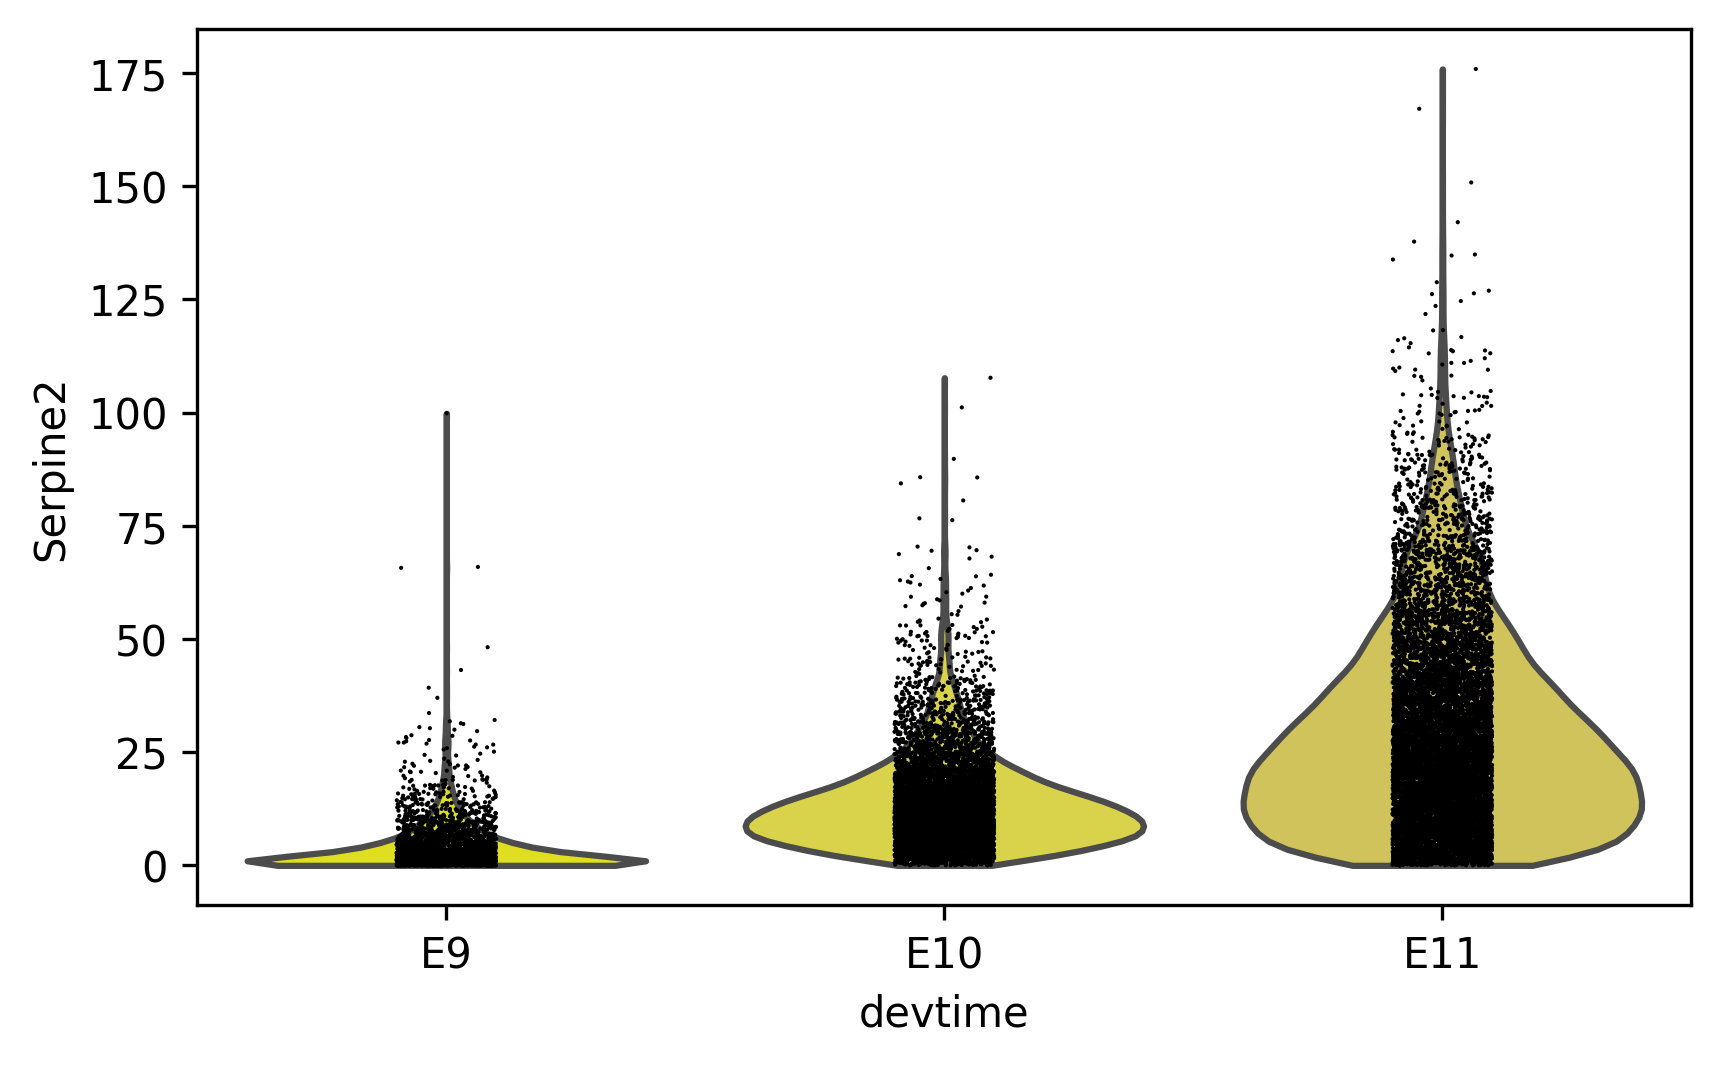

In [26]:
sc.pl.violin(adata,"Serpine2","devtime",palette=['#ffff00', '#f1e834', '#e3d248'])

In [27]:
adata.obs.loc[(adata.obs.location=="MSn") & (adata.obs.devtime=="E9"),"location"]="AN"
adata.write(f"data/adata_{marker}.h5ad")